In [22]:
# !pip install wordcloud
# !pip install konlpy

In [23]:
# %matplotlib inline

# import matplotlib as mpl  # 기본 설정
# import matplotlib.pyplot as plt  # 그래프 그리기
# import matplotlib.font_manager as fm  # 폰트 관리

# mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 현상 해결
# !apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
# !apt-get install fonts-nanum* -qq #나눔글꼴 설치


'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [1]:
import os
import json
import pickle

from konlpy.tag import Okt
from tqdm import trange

import numpy as np
import pandas as pd

from konlpy.tag import Okt # 한국어를 위한 토크나이저 Mecab 토크나이저가 가장 좋다고는 하지만, 오류떠서 일단 Okt 로
from tqdm import trange

from copy import deepcopy
from keras.callbacks import ModelCheckpoint

import re
from datetime import datetime

# 그래프를 위한 라이브러리 및 초기 그래프 설정
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")

plt.rc("font", family = "NanumGothic")
plt.rcParams["axes.unicode_minus"] = False

# 파일 저장시 파일명의 용이성
def now_time():
    now = datetime.now()
    return now.strftime('%Y%m%d_%H_%M_%S')

import pandas as pd
import numpy as np
import re
import missingno.missingno as msno

In [3]:
# fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

In [4]:
df_train = pd.read_csv('data/_1_before_prep/unsmile_train_v1.0.tsv', sep='\t')
df_valid = pd.read_csv('data/_1_before_prep/unsmile_valid_v1.0.tsv', sep='\t')

In [5]:
df = pd.concat([df_train,df_valid],axis=0)

In [6]:
display(df.head())
display(df.tail())

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
3732,저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ,0,1,0,0,0,0,0,0,0,0,0
3733,다른것보다 눈이 어떻게 저렇게 생기노.탄식.,0,0,0,0,0,0,0,0,1,0,0
3734,막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.,0,0,0,1,0,0,0,0,0,0,0
3735,‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...,1,0,0,0,0,0,0,0,0,0,0
3736,참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ,0,1,0,0,0,0,0,0,0,0,0


c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\IPython\core\events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


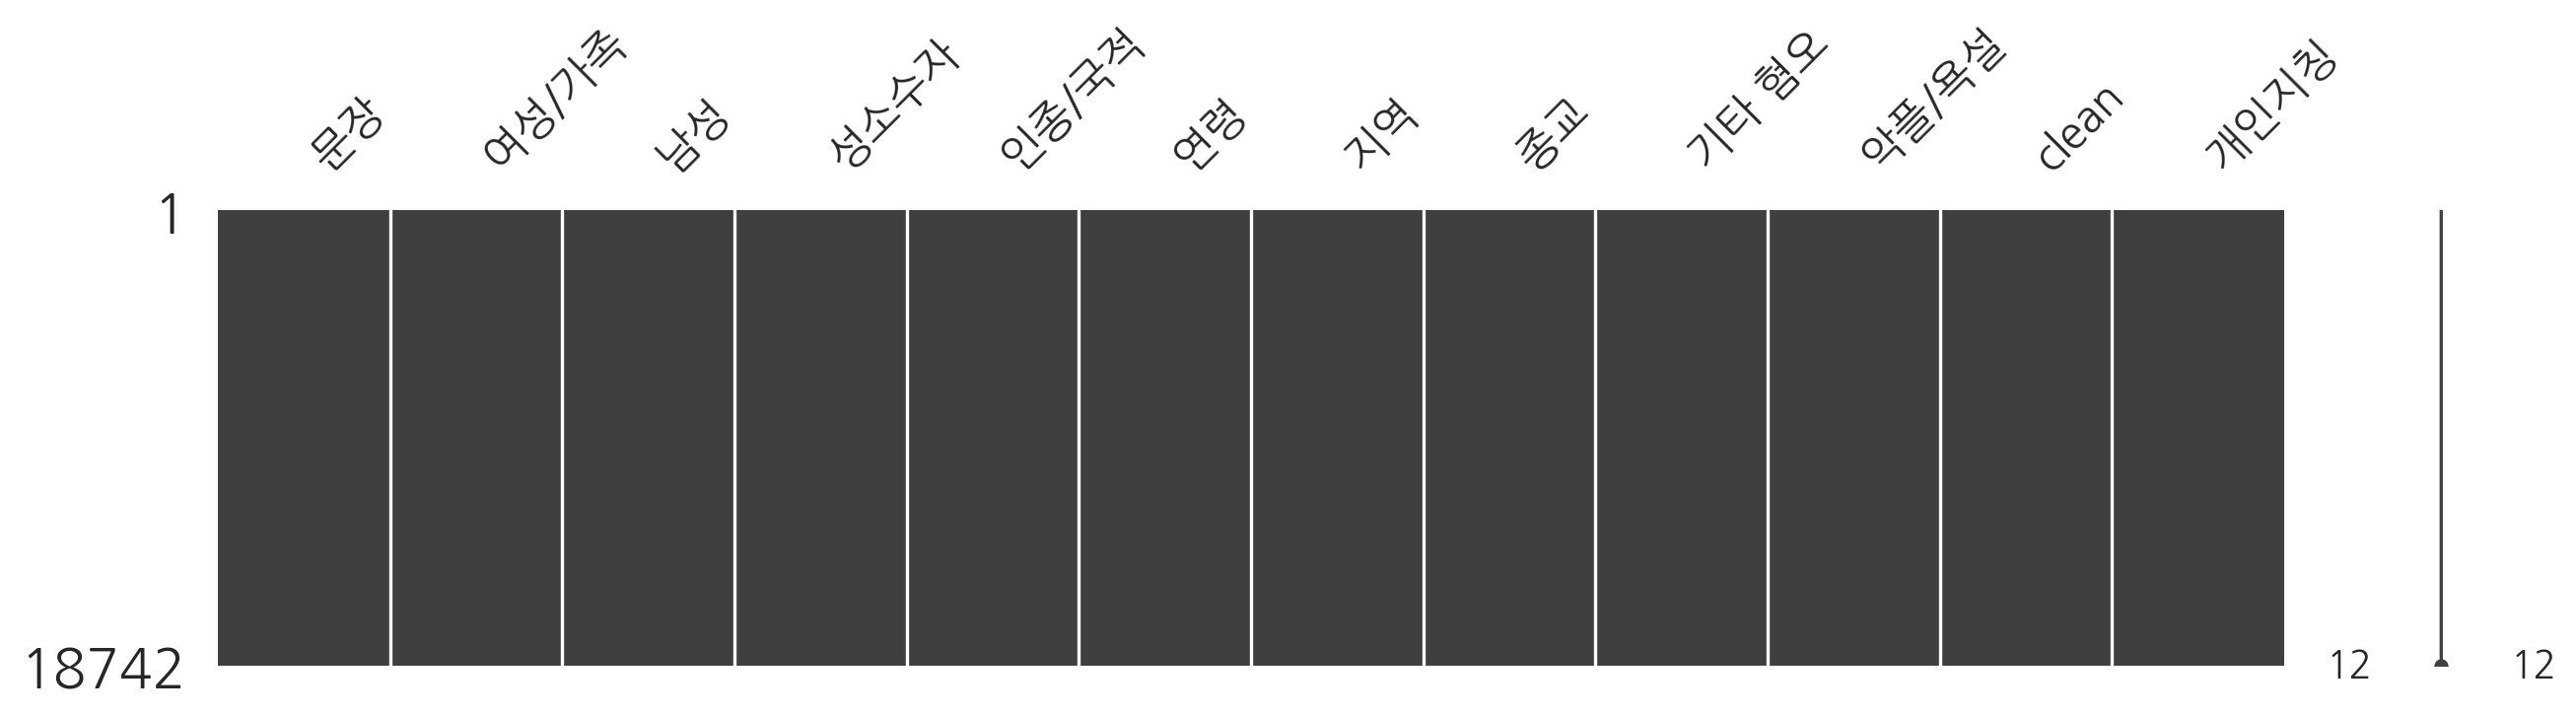

In [7]:
# na값 존재 여부  확인
msno.matrix(df, figsize=(15,3))
df.isna().sum();

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
# 각 문장의 중복 확인
print(len(df['문장'].unique()))
print(len(df['문장']))

# 중복 된 값 딱 하나 있다.
all_value = [s_ for s_ in df['문장']]
for i in set(df['문장']):
    all_value.remove(i)

# 모델에 큰 영향을 끼칠 것 같진 않다.
all_value

18741
18742


['이시국에 먼말이더냐']

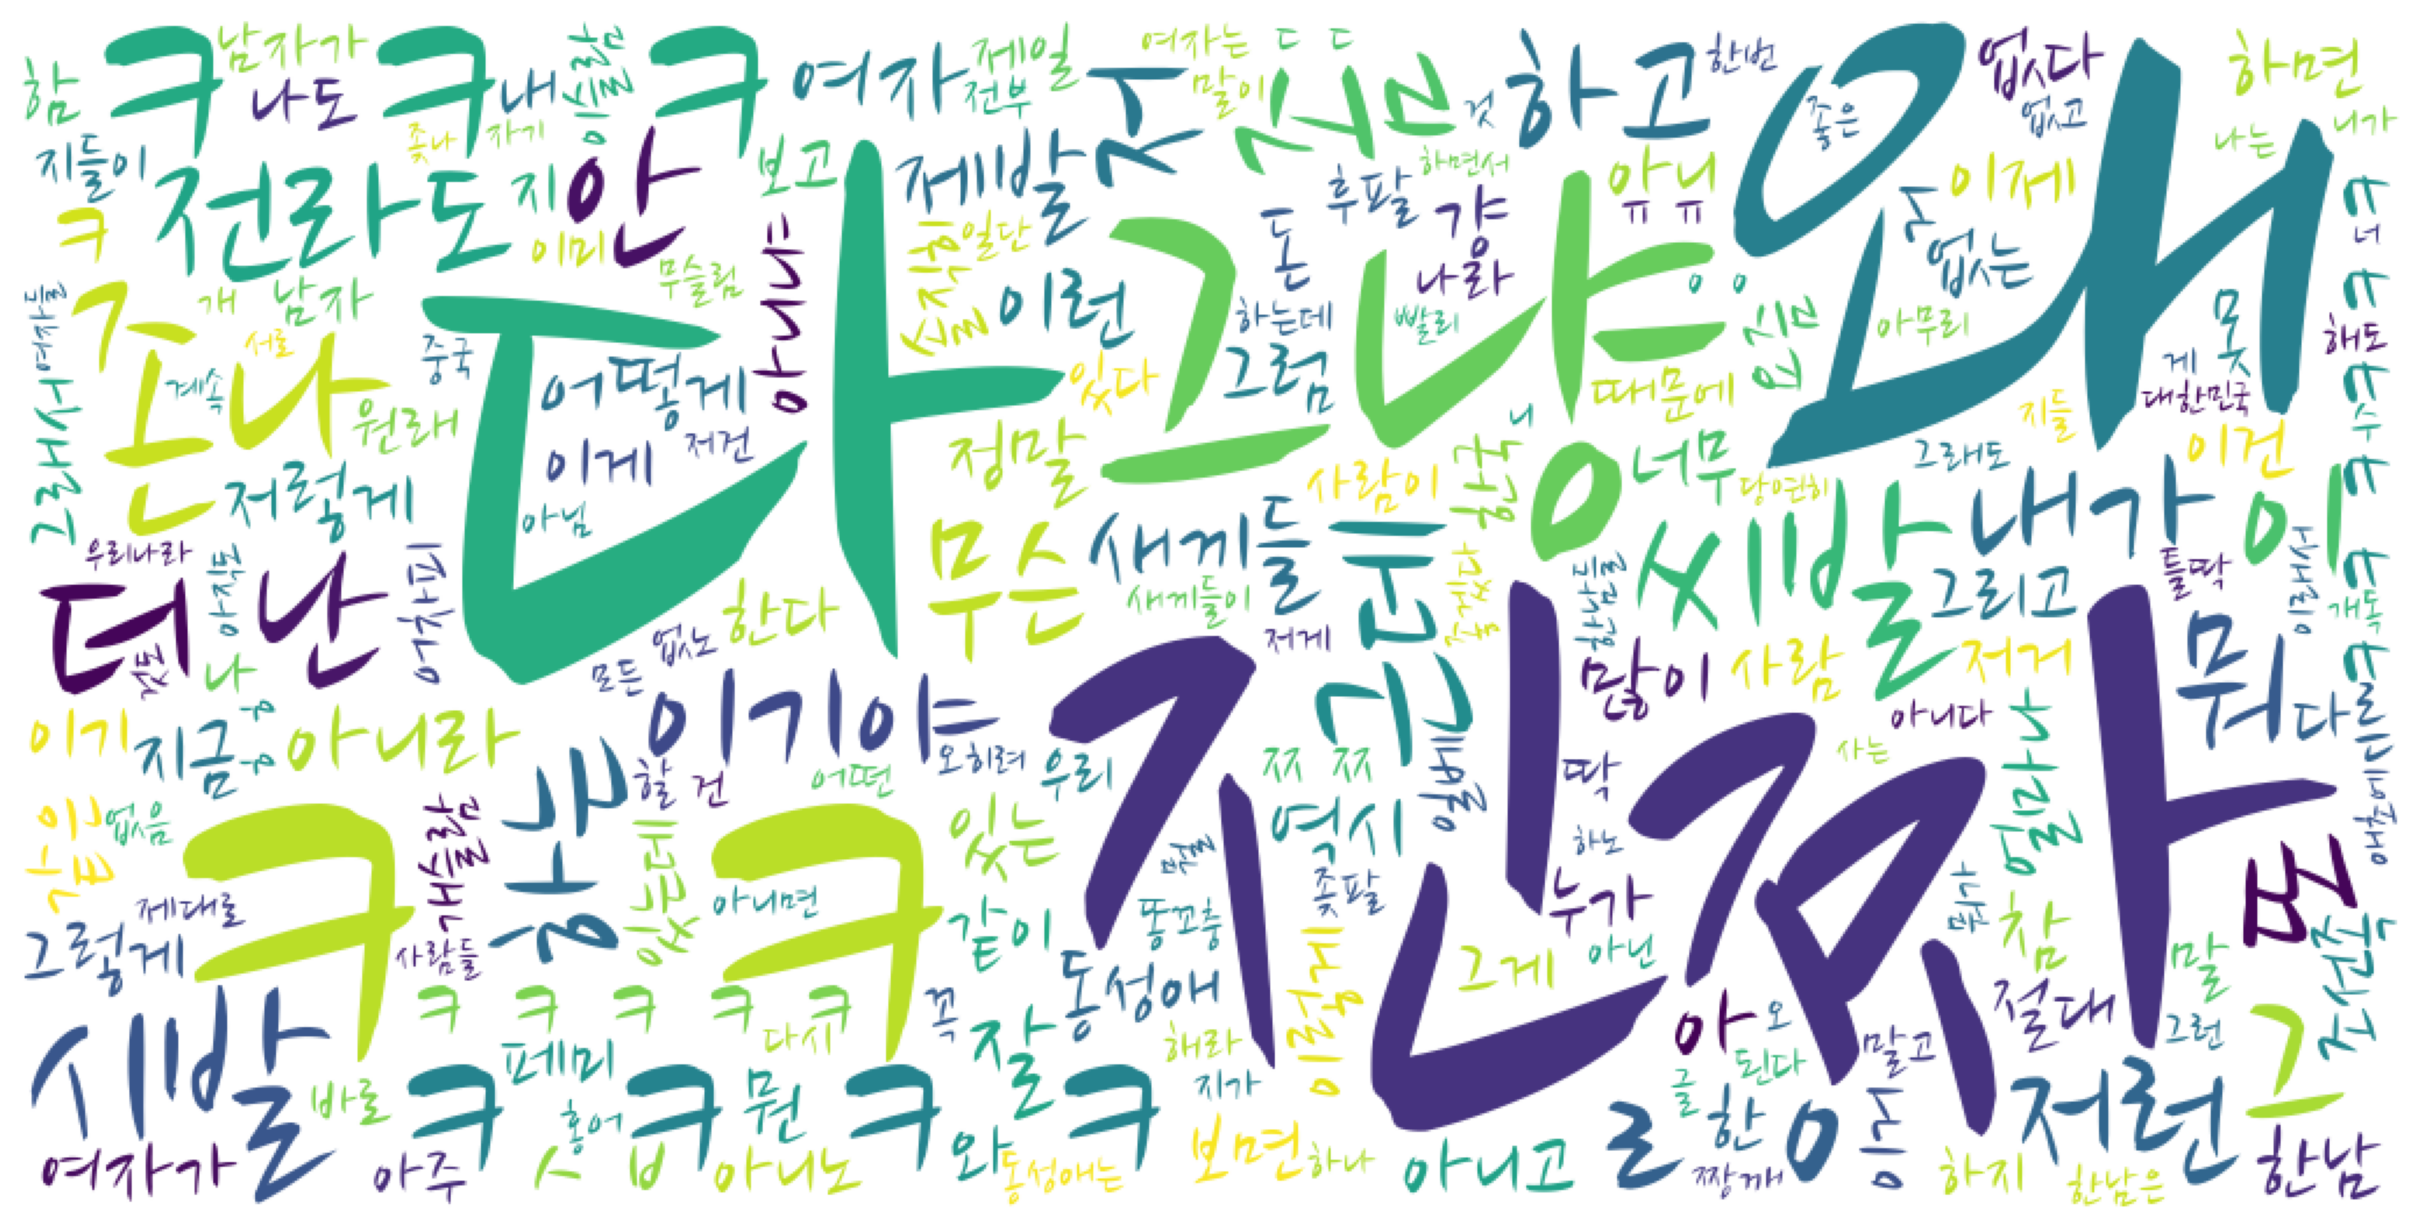

<Figure size 800x550 with 0 Axes>

In [10]:
from wordcloud import WordCloud
cloud = WordCloud(font_path=os.path.join('font/NanumBrush.ttf'),background_color='white',width=1024, height=512).generate(' '.join(df['문장'].astype(str)))
plt.figure(figsize=(12,12))
plt.imshow(cloud)
plt.axis('off')
plt.show()
plt.savefig('WordCloud.pdf')

### 문장을 의미 단위로 쪼개어 문장별 단어수 확인하기

In [11]:
# 문장 코퍼스 및 문장 토큰화 인덱싱 불러오기
with open("data/_2_after_prep/corpus_method_1/sentences.pkl","rb") as f:
    sentences = pickle.load(f)

with open("data/_2_after_prep/corpus_method_1/sentences_corpus_word_index.json","r") as f:
    corpus_word_index = json.load(f)

# 코퍼스 키와 밸류 전환 딕셔너리
corpus_index_word = {corpus_word_index[key]:key for key in corpus_word_index}

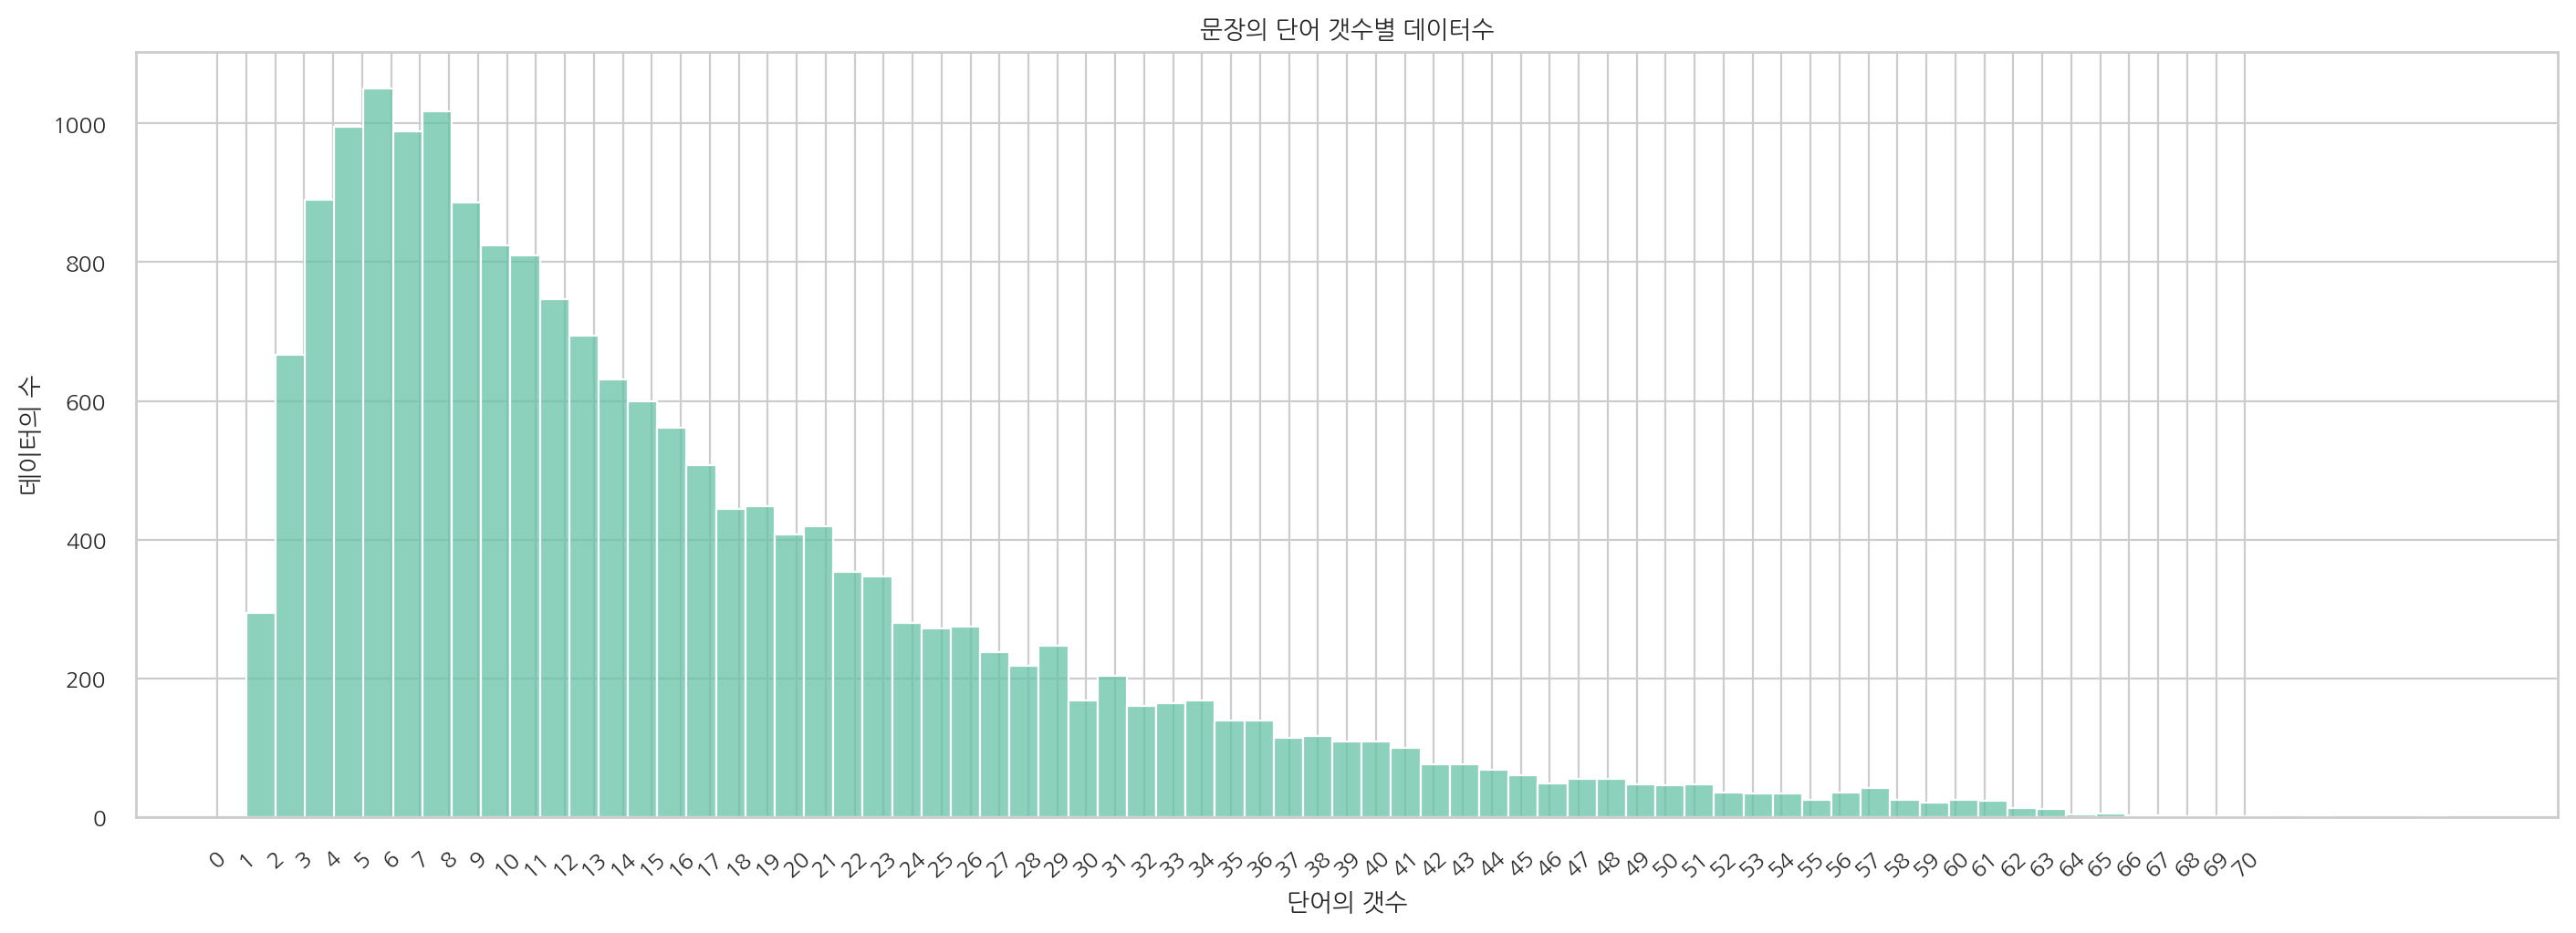

In [13]:
# 문장별 단어갯수
counts_of_sen = []

for i in range(len(sentences)):
    counts_of_sen.append(len(sentences[i]))

# 문장 길이 확인
fig, ax = plt.subplots(figsize=(14,5))
sns.histplot(counts_of_sen,bins=75,ax=ax)
ax.set_xticks(np.arange(0,71,1))
ax.set_xticklabels(np.arange(0,71,1), rotation=42)
ax.set_xlabel('단어의 갯수')
ax.set_ylabel('데이터의 수')
ax.set_title('문장의 단어 갯수별 데이터수');

In [35]:
print('의미단위의 최대, 최소 문장 수')
print(max(counts_of_sen)) # 모델에 들어갈 입력 데이터의 shape (None ,77)
print(min(counts_of_sen))

의미단위의 최대, 최소 문장 수
77
1


In [36]:
# 각 단어별 빈도수 파악하기
# 모든 문장 펴기
all_ = []
for sent in sentences:
    for word in sent:
        all_.append(word)

uniqqq_, counttt_ = np.unique(np.array(all_), return_counts=True)

# 딕셔너리 (개수, word 인덱스)
count_index = dict(zip(counttt_, uniqqq_))
# 가장 많이 사용된 단어의 갯수
how_many_uses = list(count_index.keys())

how_many_uses.sort(reverse=True)

# 가장 많이 사용된 의미 단위의 단어의 빈도수
how_many_uses_dict = {corpus_index_word[count_index[num]]:num for num in how_many_uses[:]}

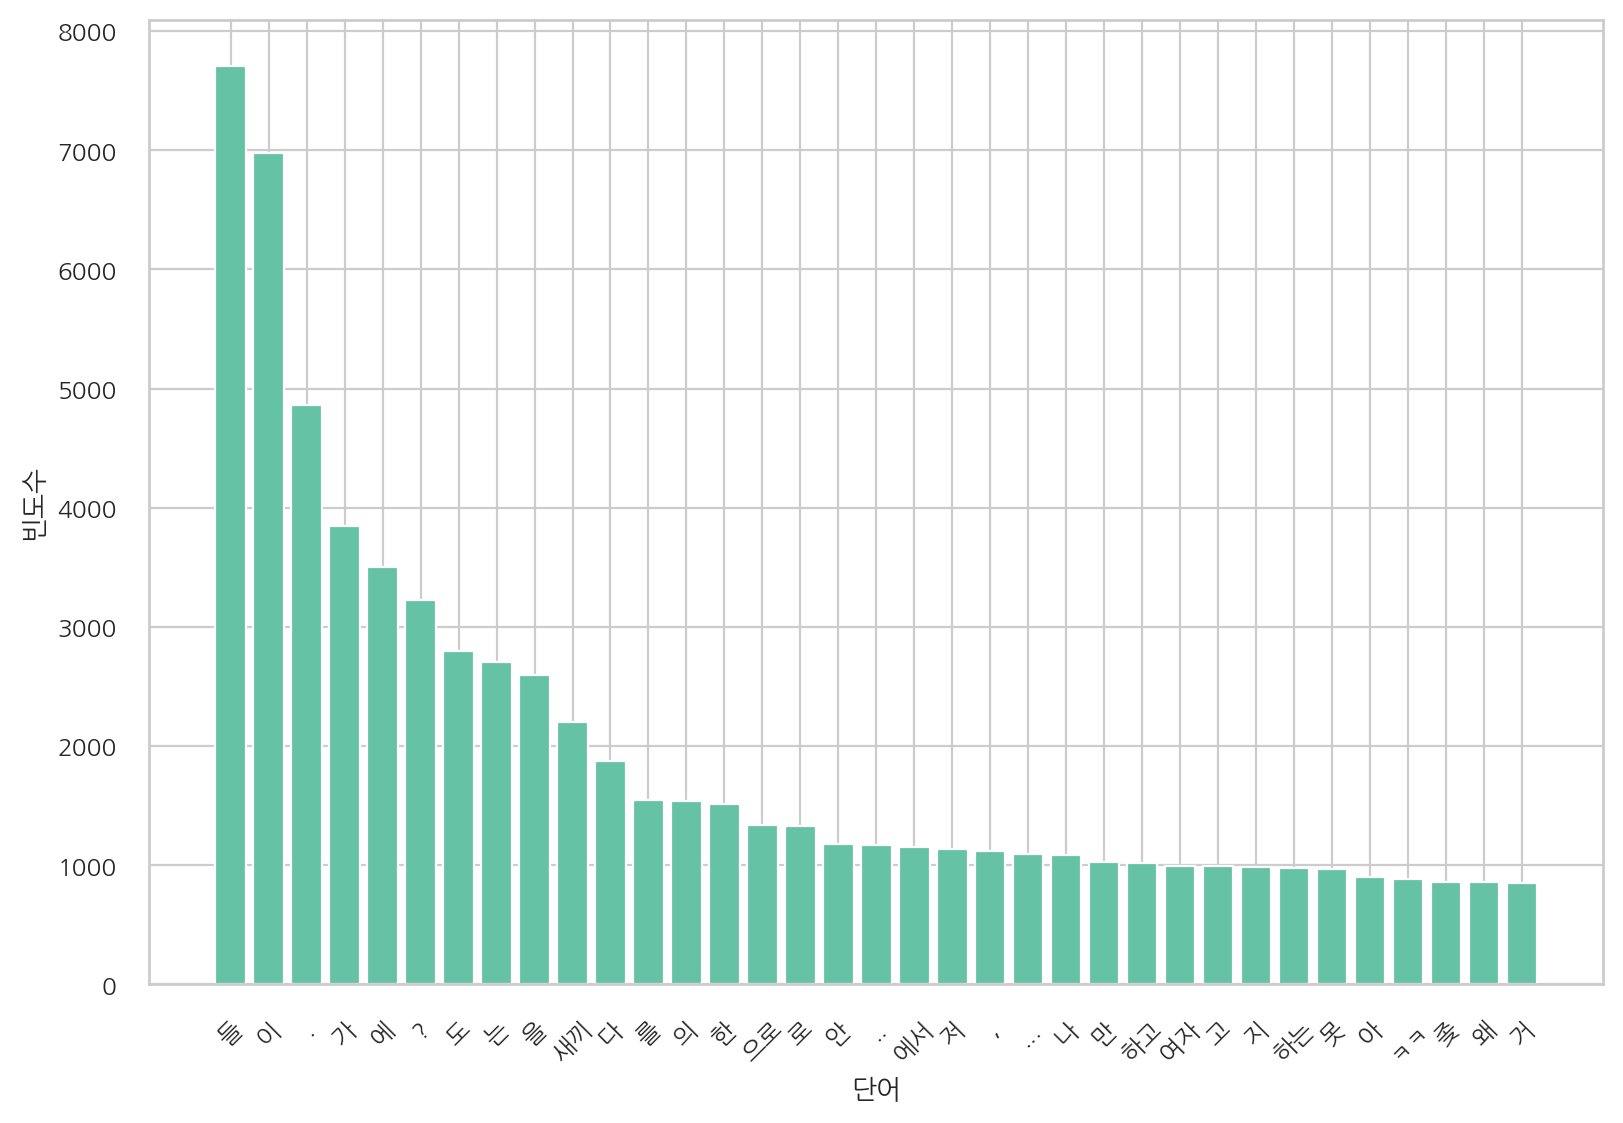

In [37]:
df_for_plot_ = pd.DataFrame([how_many_uses_dict]).T[:35]

fig, ax = plt.subplots()
ax.bar(df_for_plot_.index, df_for_plot_[0])
ax.set_xticks(df_for_plot_.index)
ax.set_xticklabels(df_for_plot_.index, rotation=45)
ax.set_xlabel('단어')
ax.set_ylabel('빈도수');

### 접사단위의 토큰이 많아 명사 단위로 변경해서 파악 해 보기

In [14]:
# 문장 분석을 위해 코퍼스 만들기
from konlpy.tag import Okt
from tqdm import trange
tokenizer = Okt()

sen_to_nouns=[]

for i in trange(len(df['문장'])):
    for noun in tokenizer.nouns(df['문장'][i]):
        sen_to_nouns.append(noun)

100%|██████████| 18742/18742 [01:40<00:00, 186.51it/s]


In [15]:
uniqqq_noun, counttt_noun = np.unique(np.array(sen_to_nouns), return_counts=True)

# 딕셔너리 (개수, word 인덱스)
count_index_noun = dict(zip(counttt_noun, uniqqq_noun))
# # 가장 많이 사용된 단어의 갯수
how_many_uses_noun = list(count_index_noun.keys())

how_many_uses_noun.sort(reverse=True)

C:\Users\crazy\AppData\Local\Temp\ipykernel_8280\3453830140.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)


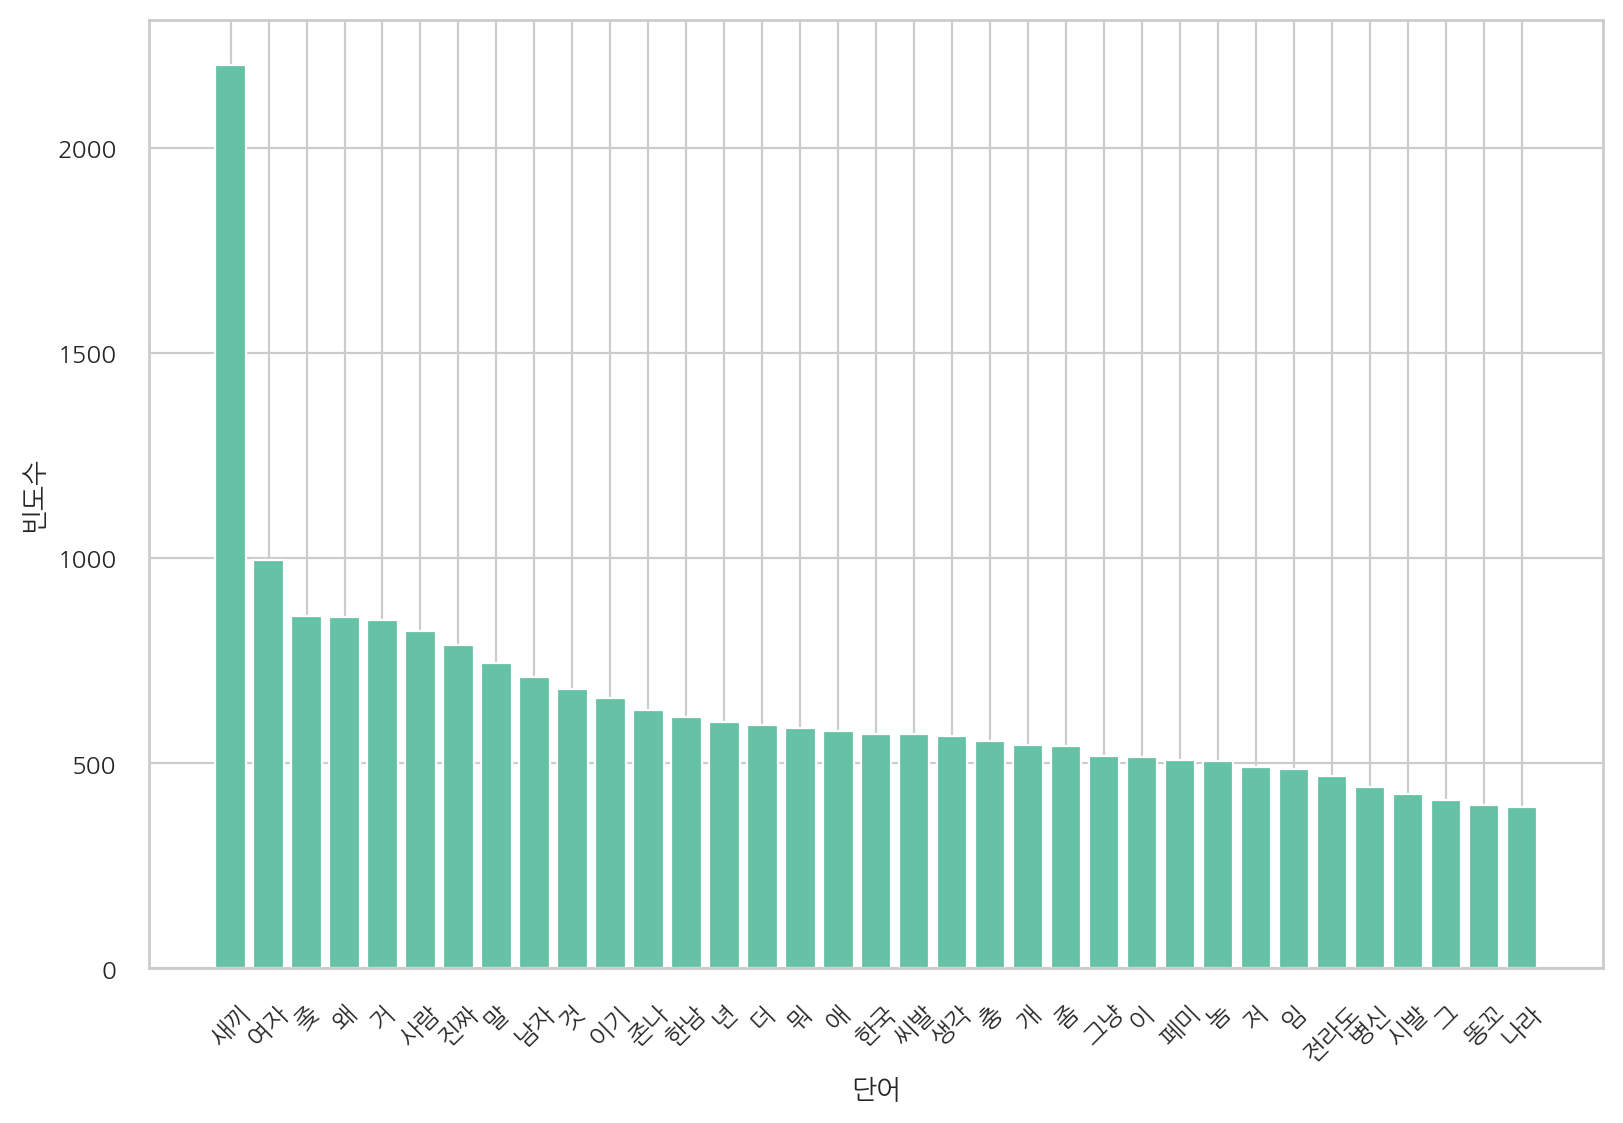

In [16]:
how_many_uses_dict_noun = {count_index_noun[i]:i  for i in how_many_uses_noun}
df_for_plot_noun = pd.DataFrame([how_many_uses_dict_noun]).T[:35]

fig, ax = plt.subplots()
ax.bar(df_for_plot_noun.index, df_for_plot_noun[0])
ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)
ax.set_xlabel('단어')
ax.set_ylabel('빈도수');

### 클러스터링 해보기

In [ ]:
# 벡터화 + 클러스터링을 위한 패키지
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

### TD-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=300)
df_tfidf = tfidf_vectorizer.fit_transform(df['문장'])

In [ ]:
tfidf_df = pd.DataFrame(df_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# tfidf_df_after = (tfidf_df[(tfidf_df != 1) & (tfidf_df != 0.0)].dropna(how='all').dropna(axis=1, how='all').fillna(value=0.0))

morethan_5 = {}
for i in range(0,len(tfidf_df)):
    filter_col = [col for col in tfidf_df.iloc[i] != 0.0]
    filtered_col = [i for i in tfidf_df.columns * np.array(filter_col) if i != '']

    to_dict_ = tfidf_df.iloc[i][filtered_col].to_dict()
    if len(to_dict_) > 5:
        morethan_5[df.loc[i,'문장']] = tfidf_df.iloc[i][filtered_col].to_dict()

In [ ]:
morethan_5

{'다문화 극혐 맞고 다인종도 위험하긴 한데어차피 일베서 아무리 극혐씹극혐 소리 해봤자 변하는거 없음 뭐 존나 뭉쳐서 시위해야 윗대가리들이 들을랑말랑하는데 우리 일베충들이 그럴 위인들이 얼마나 있을까?그냥 글러먹었다 생각하고 자기살길이나 찾으면 된다': {'그냥': 0.24839475172844194,
  '극혐': 0.3746278554094652,
  '다문화': 0.37584872904980793,
  '된다': 0.35815687186437556,
  '아무리': 0.35229676496940965,
  '얼마나': 0.31791946924350295,
  '없음': 0.348474564450171,
  '우리': 0.3415680066628157,
  '존나': 0.2551987078664628},
 '걍 서로 인정하고 선을 그으면 될 문제를 왜 니들끼리 지적하고 니가잘났니 내가 잘났니 싸우고 있노 내가 한남국자면 이거 보고 3번은 사정했다 이기': {'내가': 0.6188014791390786,
  '보고': 0.3440415541054602,
  '서로': 0.37566636539717596,
  '이거': 0.33008774863206203,
  '이기': 0.3244336266736046,
  '있노': 0.3786552791916314},
 '근데 나만 그런지 모르겠는데 디씨 히어로들은 정이 안가. 매력이 너무 없음 다 그냥 ㅈㄴ쎄. 아이언맨처럼 어떻게 히어로가 됬는지. 어떤 단점, 트라우마를 끌어안고 있는지 전혀 입체적이지 않음': {'그냥': 0.3275097979114798,
  '근데': 0.3616714883376116,
  '너무': 0.40055571245182026,
  '어떤': 0.47107435222878646,
  '어떻게': 0.4104467567194906,
  '없음': 0.4594655619179025},
 '야 근데 계속 보지보지 라고하는거 겁나 듣기 싫다..그냥 성기 라고 하면 안되냐 ???? 보지라는 단어는 

결과
- 각 문장에서 중요해 보이는 단어의 정도를 알 수 있다.

In [ ]:
morethan_5['원래 학생 때 기성 가치에 반항해야할 것 같은 헛바람이 들기 마련이다.\
 사회 나가서 이리저리 깨지고 스스로 돈 벌어보면 과거의 자신이 그렇게 창피할 수가 없음.\
 내가 그랬거든. 근데 나이 처먹고도 정신 못 차리는 애들도 가끔 있어']
# 이문장에서 중요해 보이는(다른문장들 보다 더 자주 쓰이는) 단어들

{'같은': 0.363183651570905,
 '그렇게': 0.3768341155107114,
 '근데': 0.31850490699127243,
 '내가': 0.3451171893013133,
 '스스로': 0.4309273706292435,
 '없음': 0.4046269633722067,
 '원래': 0.3951215714750072}

In [ ]:
morethan_5['적당히 해야지 재는 뭐 남들과 다른 주장을 하면 지가 특별한 \
지식인처럼 보인다는 강박이 있는거같다 서민교수는 담백해서 보기좋은데 오바도 없고 저새낀 \
그냥 모든게 뭔가 다 가식같아 이러면 날 특별하게 주변에서 볼것이다 뭐 이런게 있는거 같애']

{'그냥': 0.30260699469422714,
 '다른': 0.40524695354087953,
 '뭔가': 0.46587517575281406,
 '없고': 0.4311462940298563,
 '지가': 0.44078829905392414,
 '하면': 0.38338333634460153}

### word2vec 및 fastVec

In [ ]:
from gensim.models import Word2Vec ,FastText

In [ ]:
def vectorize_w_word2vec(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [ ]:
sentence_words_list = [[corpus_index_word[j] for j in i ] for i in sentences]
w2v_model = Word2Vec(sentence_words_list, vector_size=128, window=5, min_count=1)
fst_model = FastText(sentence_words_list, vector_size=128, window=5, min_count=1)

In [ ]:
text_vector_ = np.array([vectorize_w_word2vec(text_, w2v_model) for text_ in df['문장']])

In [ ]:
print('wrod2vec')
for i in w2v_model.wv.most_similar('자격증'):
    print(i)
print('\nfastmodel')
for i in fst_model.wv.most_similar('시험'):
    print(i)

wrod2vec
('상승', 0.9094120860099792)
('부엉이', 0.9080016016960144)
('시방', 0.9077597856521606)
('답임', 0.9074140191078186)
('싶음', 0.9073854684829712)
('혐', 0.9066224098205566)
('않네', 0.9060940146446228)
('만들어라', 0.9058794379234314)
('보자', 0.9058720469474792)
('손잡고', 0.905800998210907)

fastmodel
('뜯기도', 0.9993669986724854)
('힘들어진다', 0.9993651509284973)
('건강하길', 0.9992746114730835)
('같기도', 0.999265193939209)
('누군가', 0.999259889125824)
('준비', 0.9992385506629944)
('영원히', 0.9991846680641174)
('disgusting', 0.9991611838340759)
('엔', 0.9991491436958313)
('감', 0.9991422295570374)


In [ ]:
kmeans_ = KMeans(n_clusters=11)
kmeans_.fit(text_vector_)

df['cluster'] = kmeans_.labels_

In [ ]:
# 클러스터별 분류로 볼때는 단순한 모델로는 수렴이 쉬워 보이진 않는다.
# 클러스터링을 했음에도 많이 섞여있는 것을 보여준다.
# 각 클러스터별, 카테고리 갯수

for cluster in range(11):
    print(f"C#{cluster:02d} = ", end="")
    # display(df[df['cluster'] == cluster][['문장']])
    for i,j in zip(df.columns.to_list(),df[df['cluster'] == cluster].iloc[:,1:].sum().tolist()):
        print(f'{i}:{j: 5d}, ',end="")
    print("")

C#00 = 문장:  212, 여성/가족:  209, 남성:  157, 성소수자:  254, 인종/국적:   94, 연령:  134, 지역:  136, 종교:   87, 기타 혐오:  450, 악플/욕설:  599, clean:   66, 개인지칭:    0, 
C#01 = 문장:  167, 여성/가족:  115, 남성:  135, 성소수자:  149, 인종/국적:   40, 연령:   89, 지역:  125, 종교:   47, 기타 혐오:  219, 악플/욕설:  264, clean:   20, 개인지칭: 1247, 
C#02 = 문장:  398, 여성/가족:  328, 남성:  263, 성소수자:  383, 인종/국적:  170, 연령:  330, 지역:  260, 종교:  139, 기타 혐오: 1045, 악플/욕설: 1624, clean:   71, 개인지칭: 9396, 
C#03 = 문장:   20, 여성/가족:   35, 남성:   28, 성소수자:   41, 인종/국적:   18, 연령:   38, 지역:   27, 종교:    6, 기타 혐오:  124, 악플/욕설:   84, clean:    7, 개인지칭: 1206, 
C#04 = 문장:  287, 여성/가족:  213, 남성:  204, 성소수자:  300, 인종/국적:   93, 연령:  154, 지역:  210, 종교:   87, 기타 혐오:  445, 악플/욕설:  469, clean:   46, 개인지칭: 9084, 
C#05 = 문장:  363, 여성/가족:  320, 남성:  255, 성소수자:  397, 인종/국적:  116, 연령:  196, 지역:  265, 종교:  134, 기타 혐오:  568, 악플/욕설:  591, clean:   66, 개인지칭: 14735, 
C#06 = 문장:  100, 여성/가족:   76, 남성:   75, 성소수자:  114, 인종/국적:   49, 연령:   90, 지역:   77, 종교:   36, 기타 혐오:  198, 악플/욕설:  2

100%|██████████| 1993/1993 [00:16<00:00, 122.76it/s]
C:\Users\crazy\AppData\Local\Temp\ipykernel_23424\3399911650.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)
100%|██████████| 1681/1681 [00:14<00:00, 118.68it/s]
C:\Users\crazy\AppData\Local\Temp\ipykernel_23424\3399911650.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)
100%|██████████| 1421/1421 [00:13<00:00, 107.82it/s]
C:\Users\crazy\AppData\Local\Temp\ipykernel_23424\3399911650.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)
100%|██████████| 2154/2154 [00:17<00:00, 120.63it/s]
C:\Users\crazy\AppData\Local\Temp\ipykernel_23424\3399911650.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_for_plot_noun.i

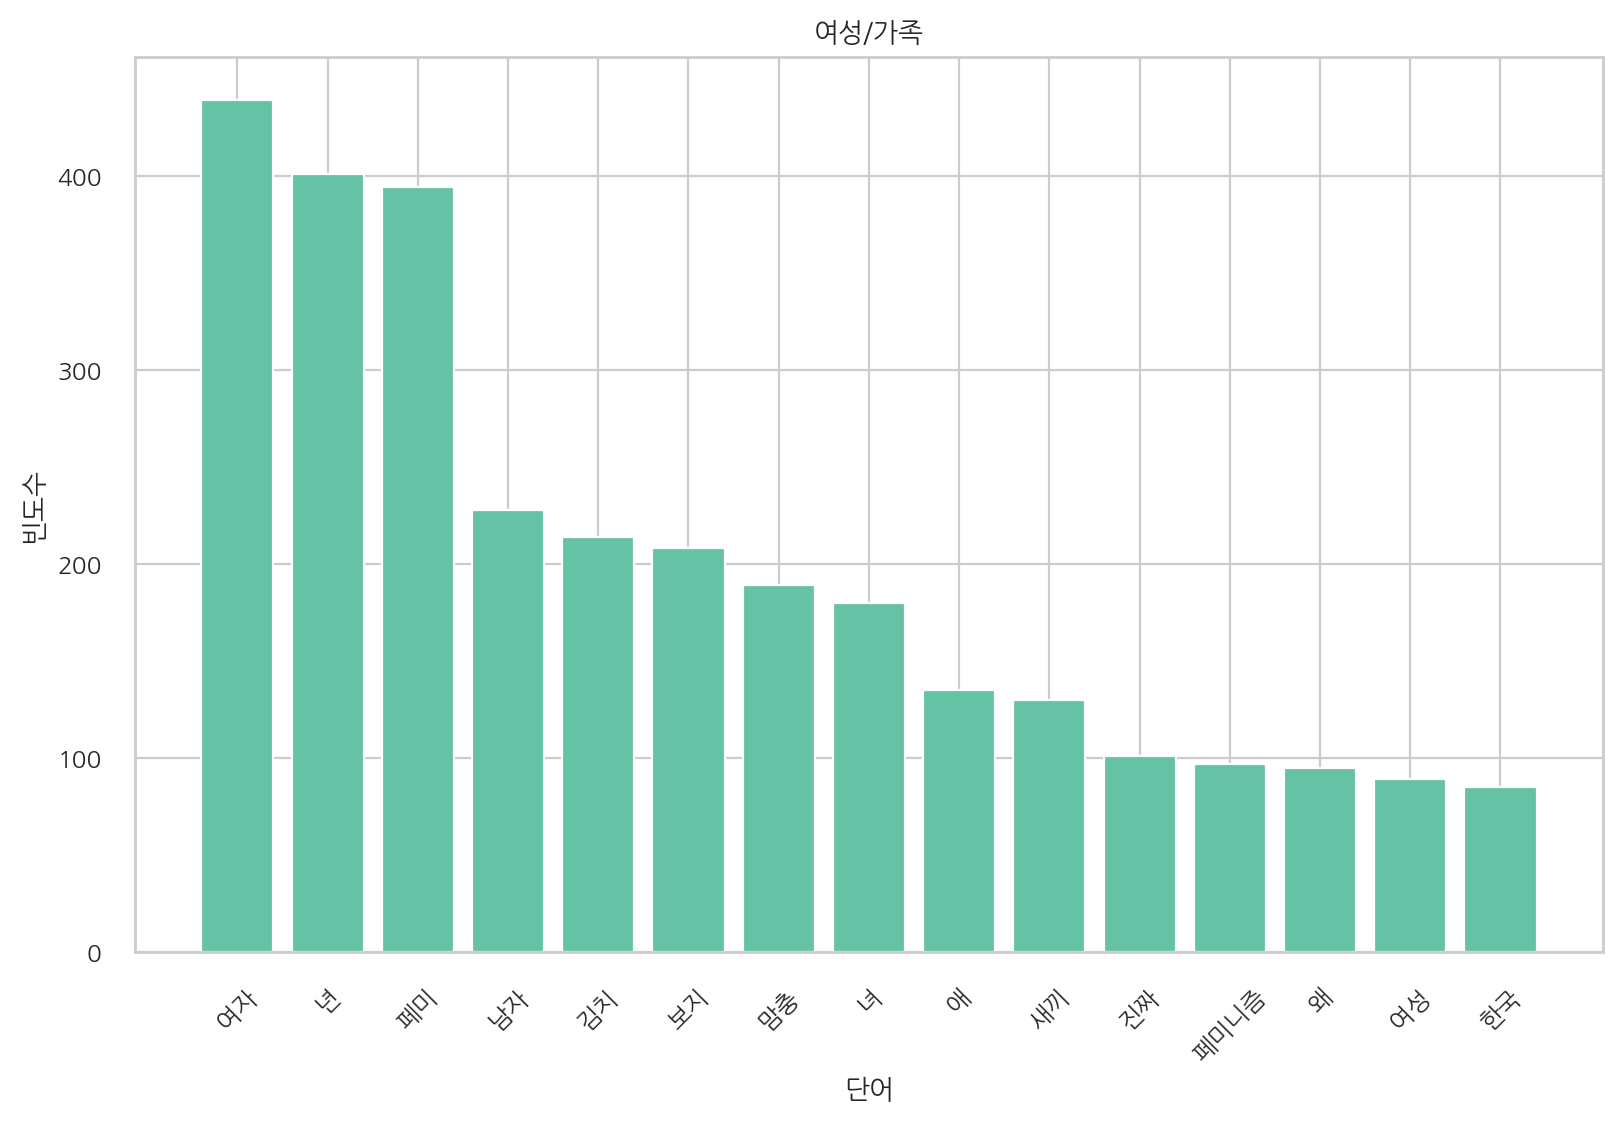

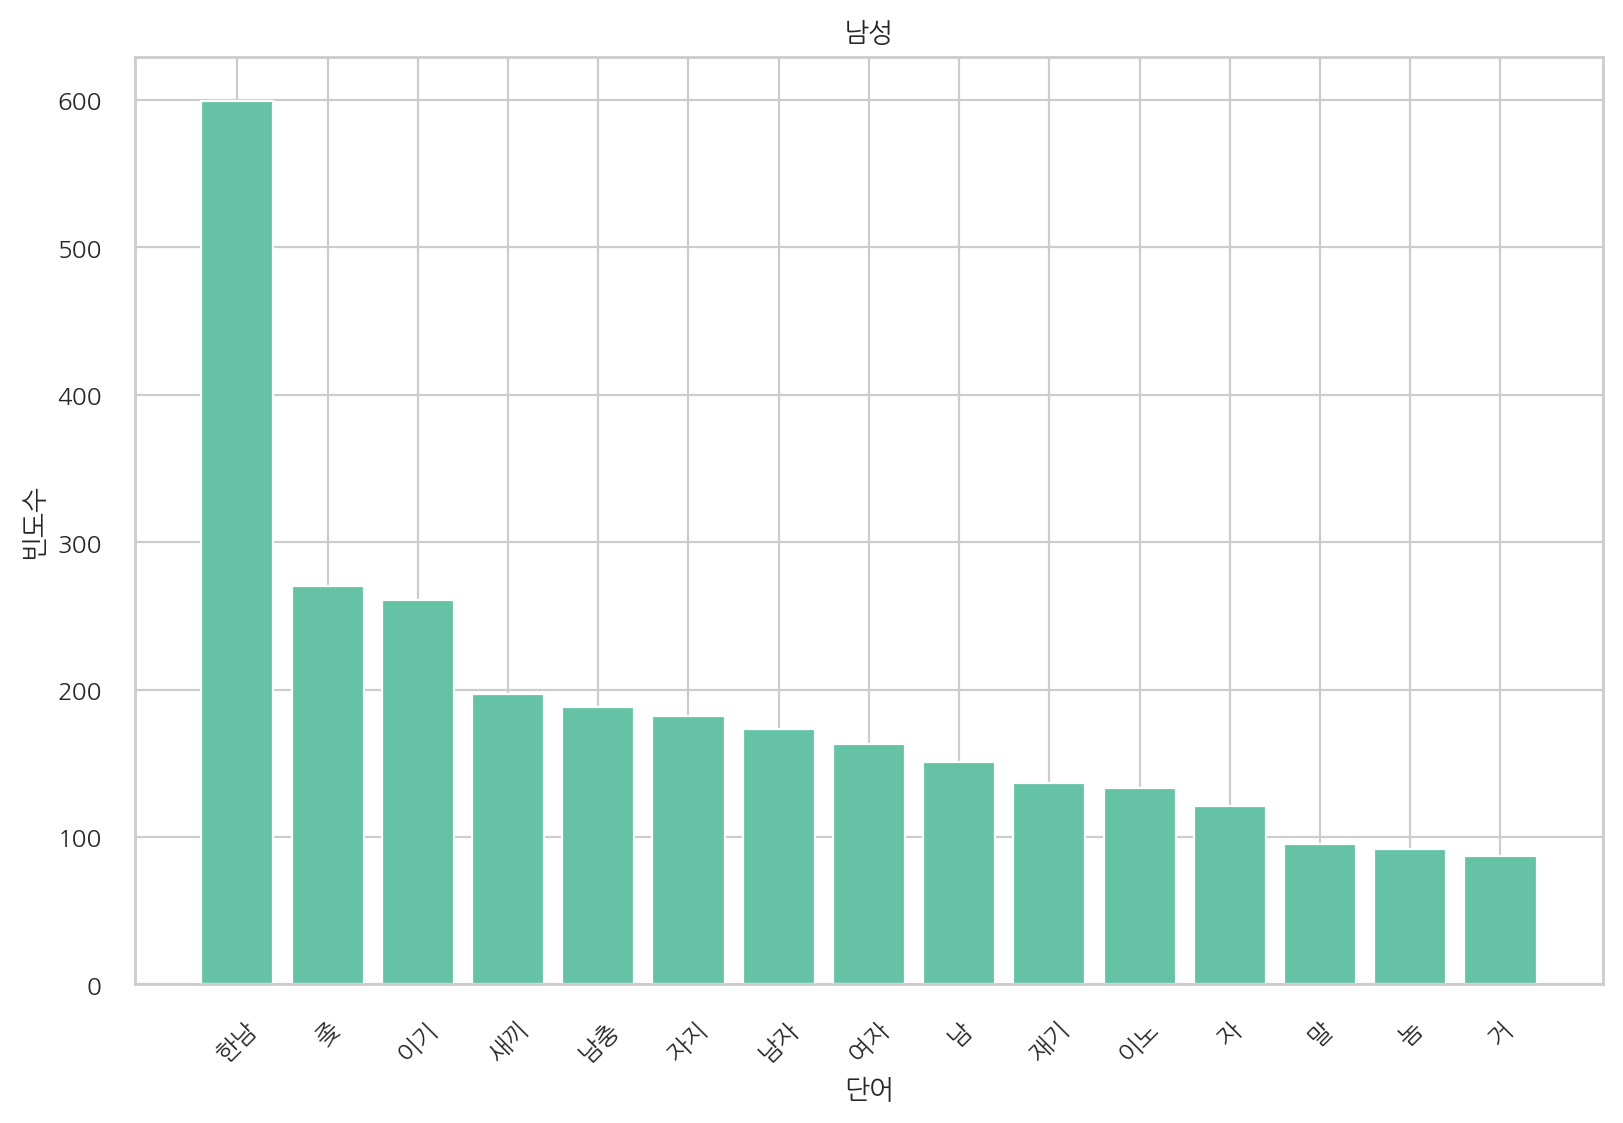

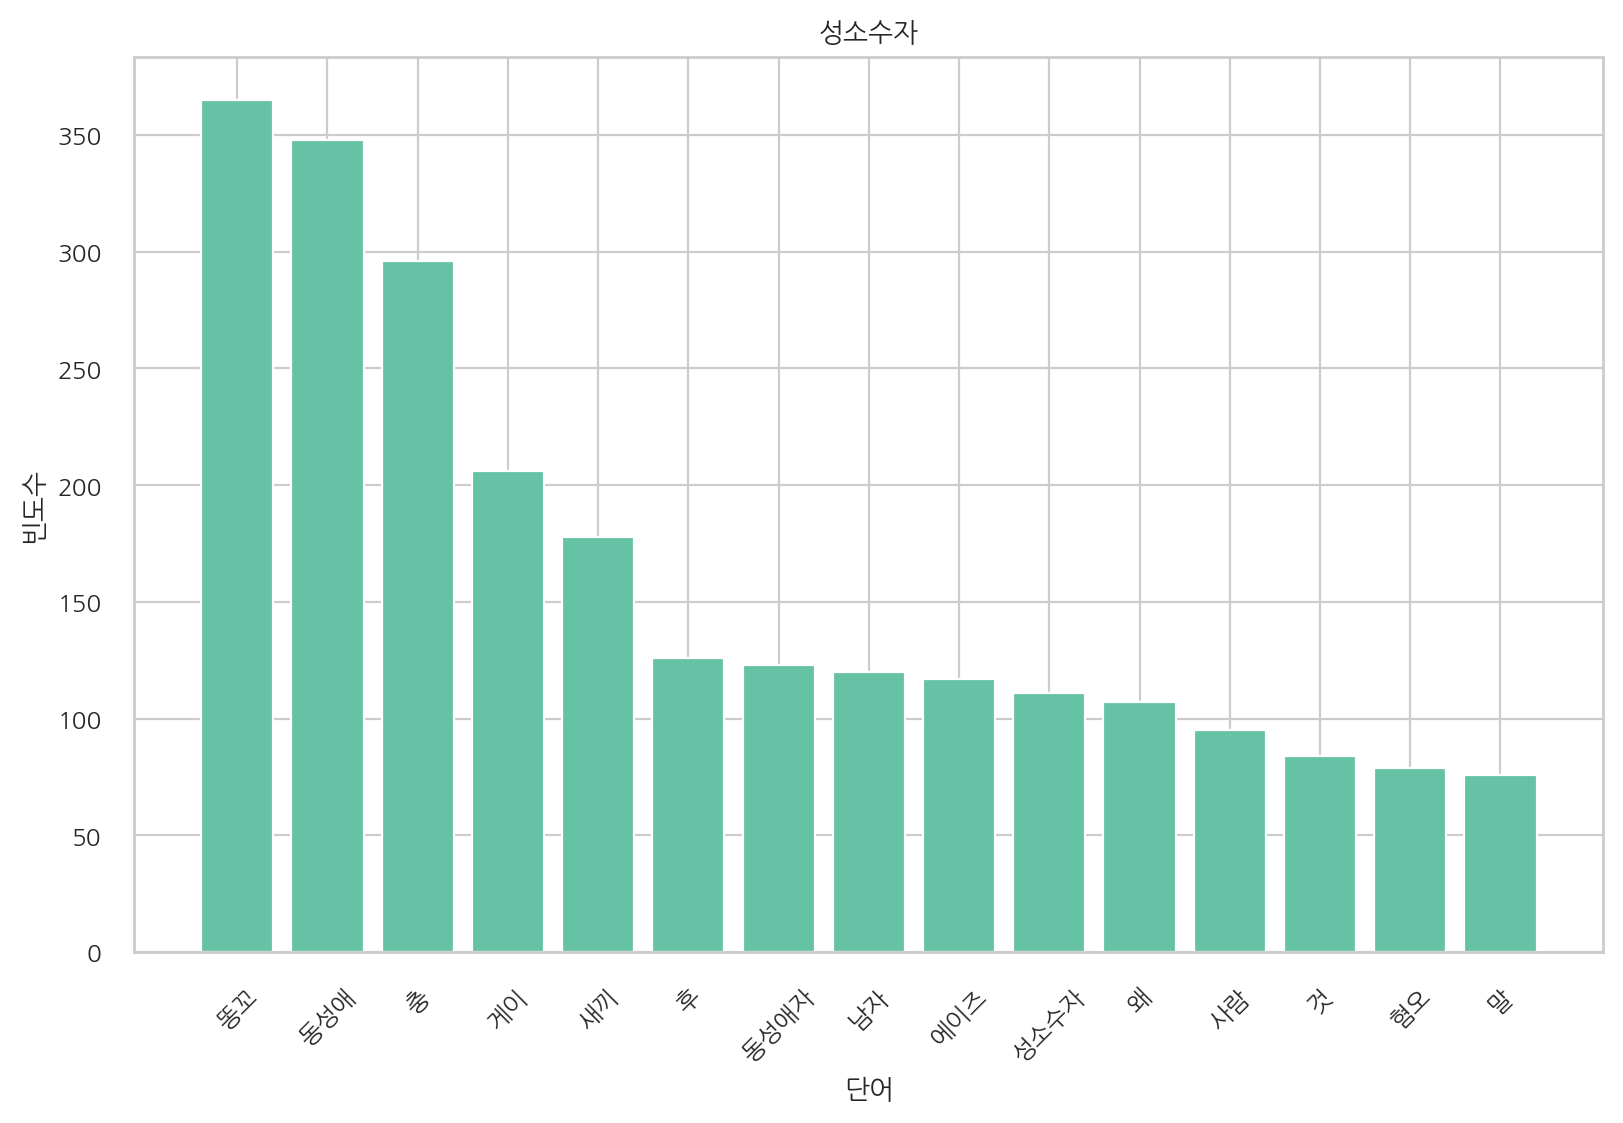

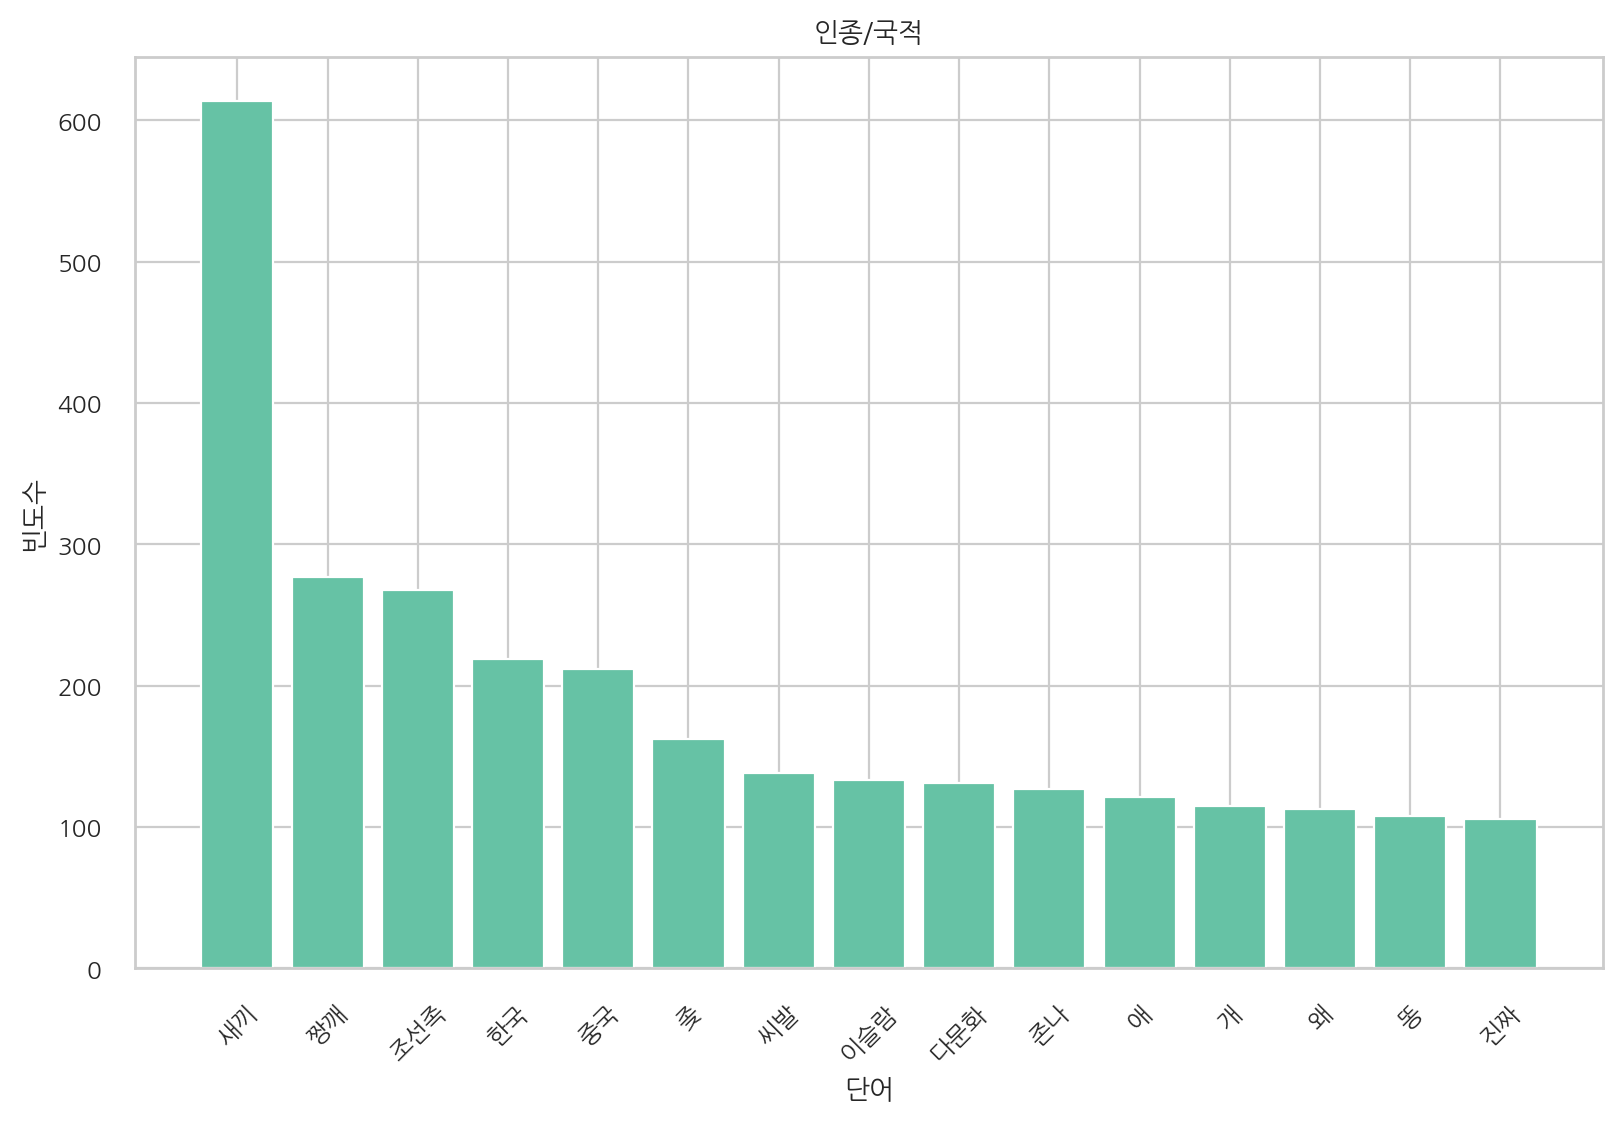

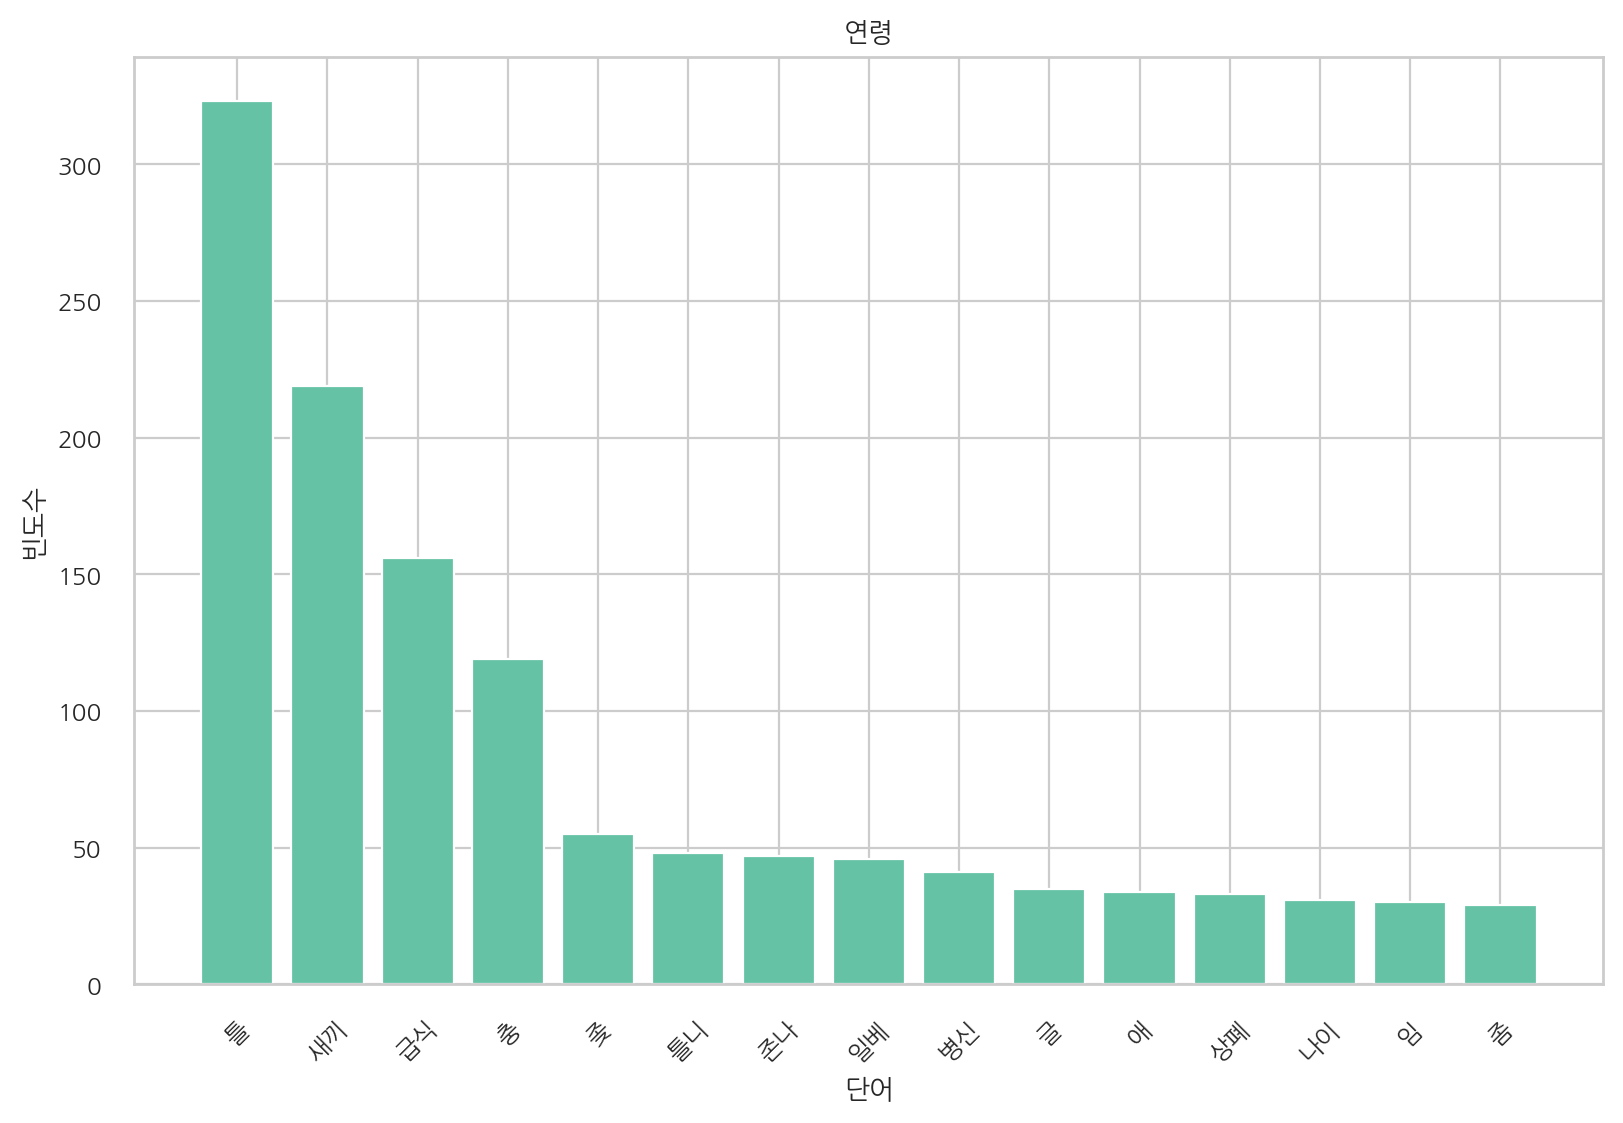

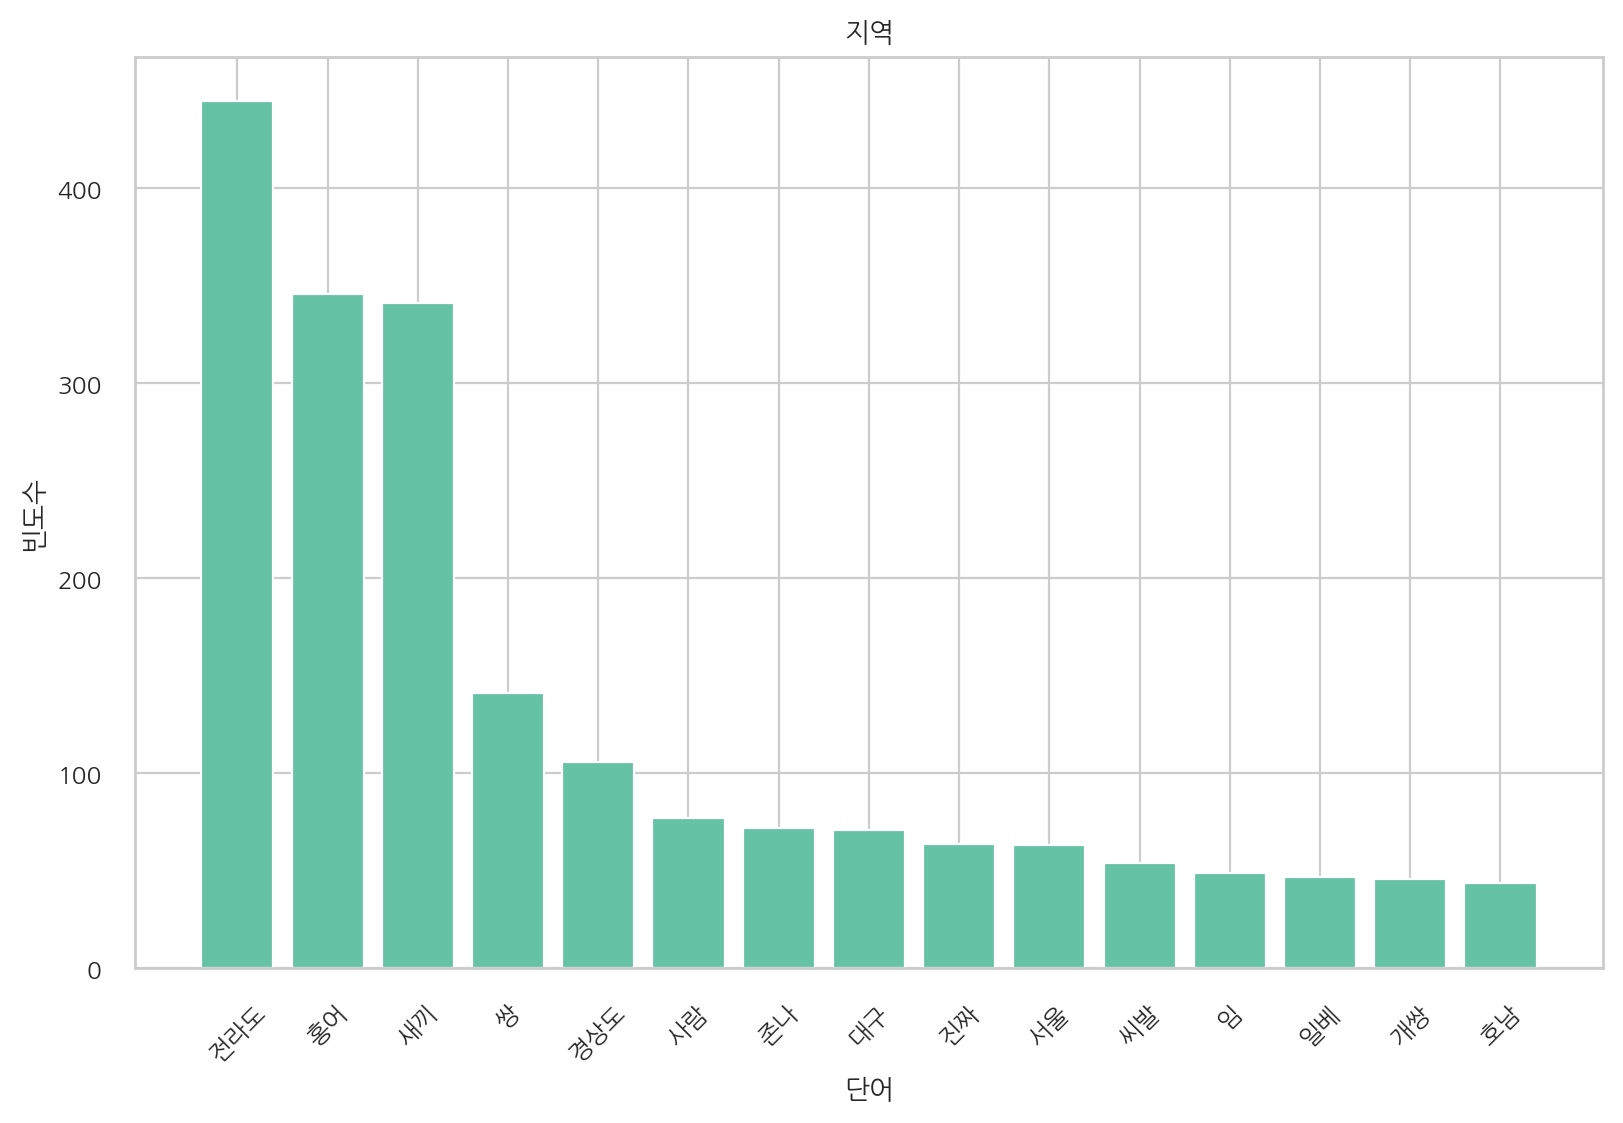

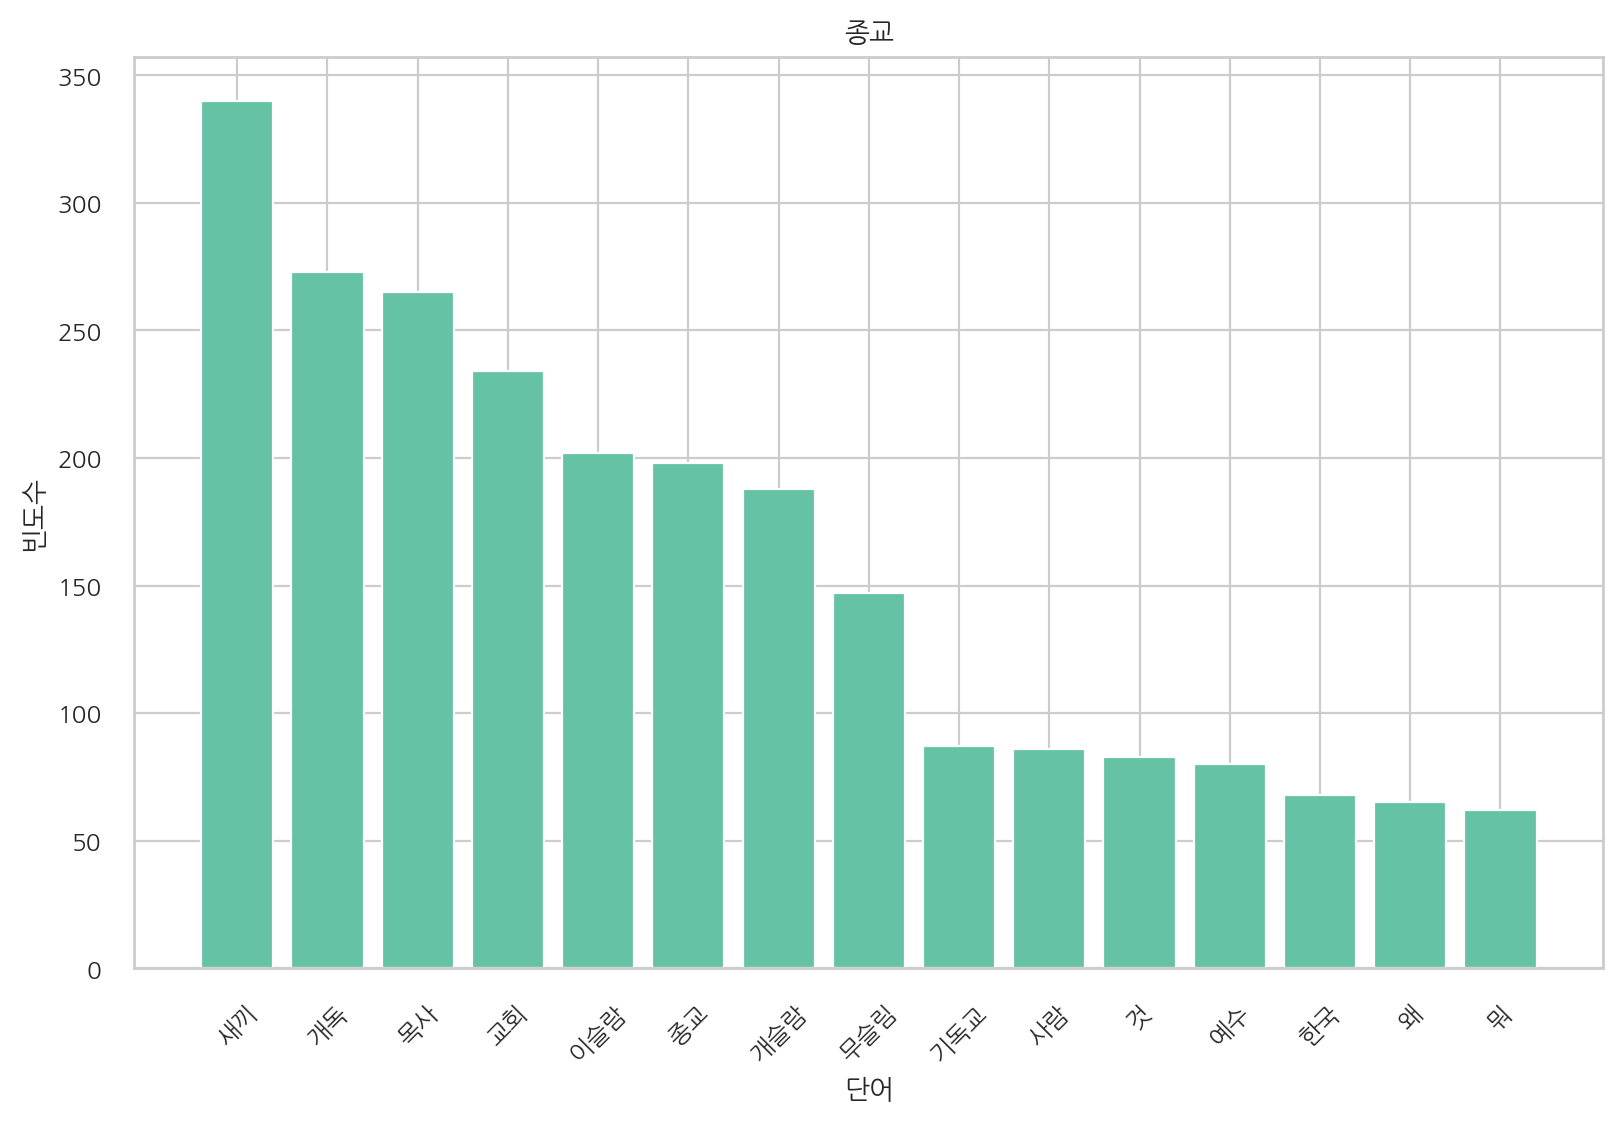

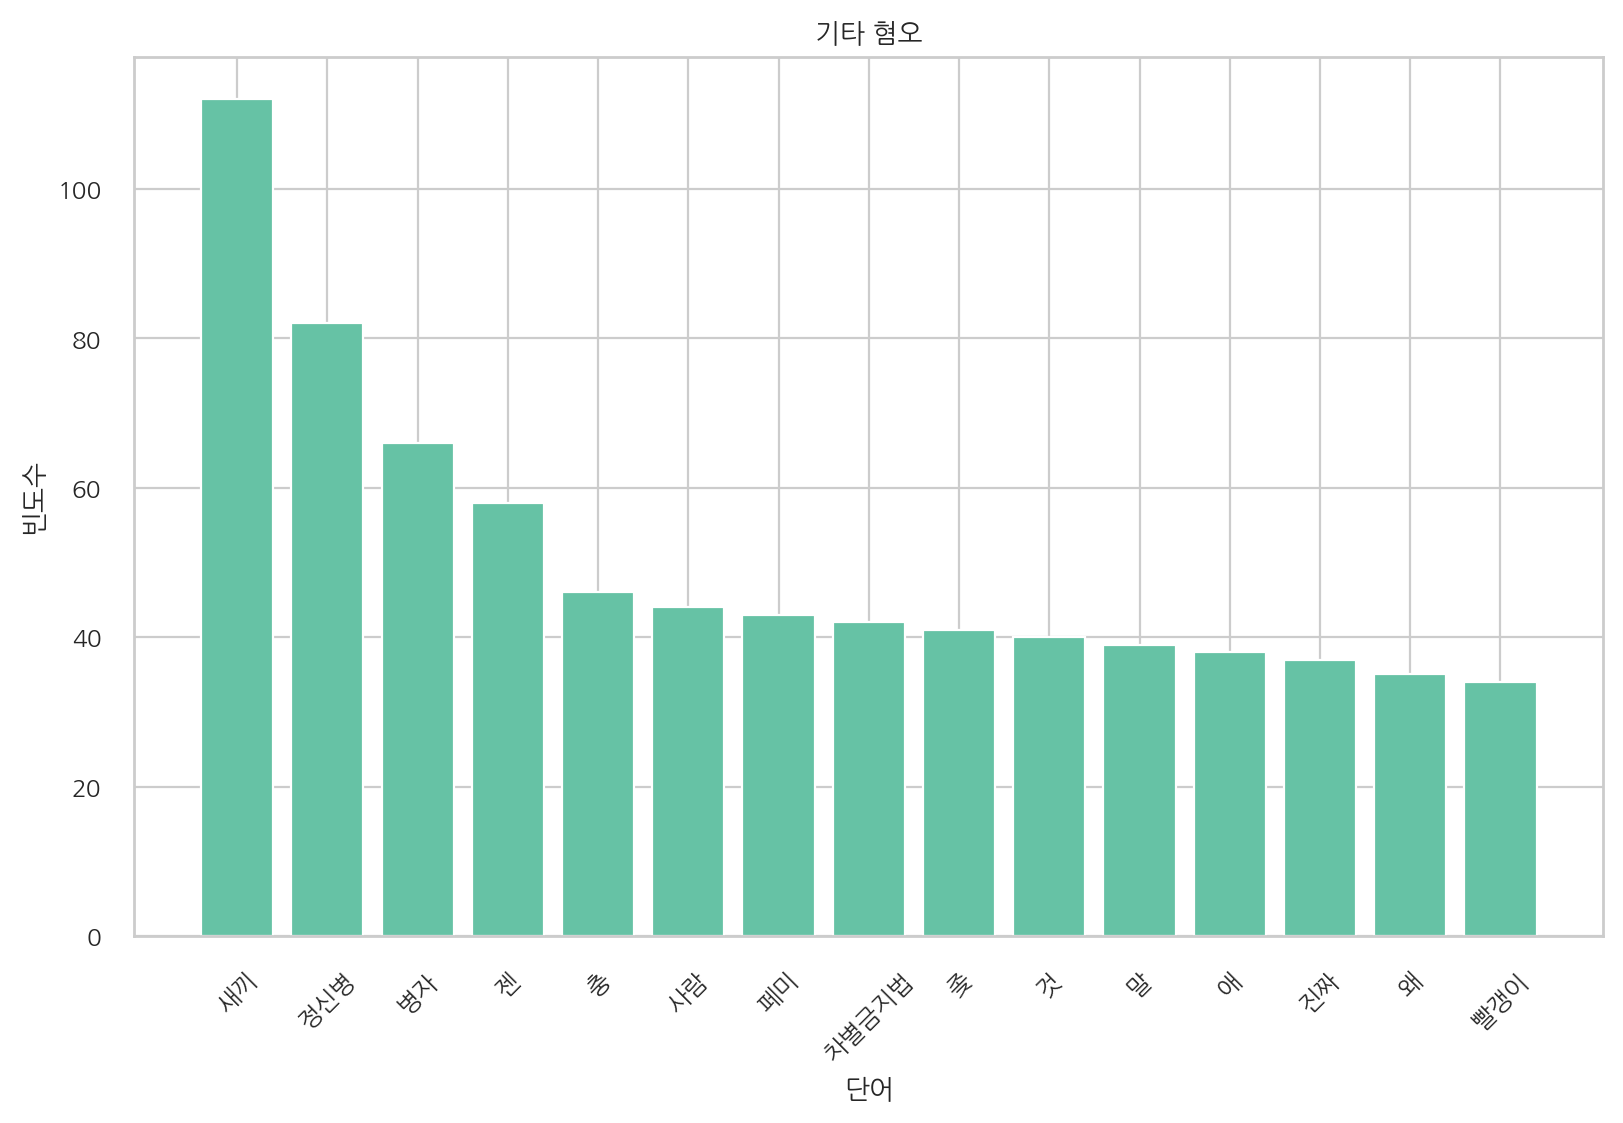

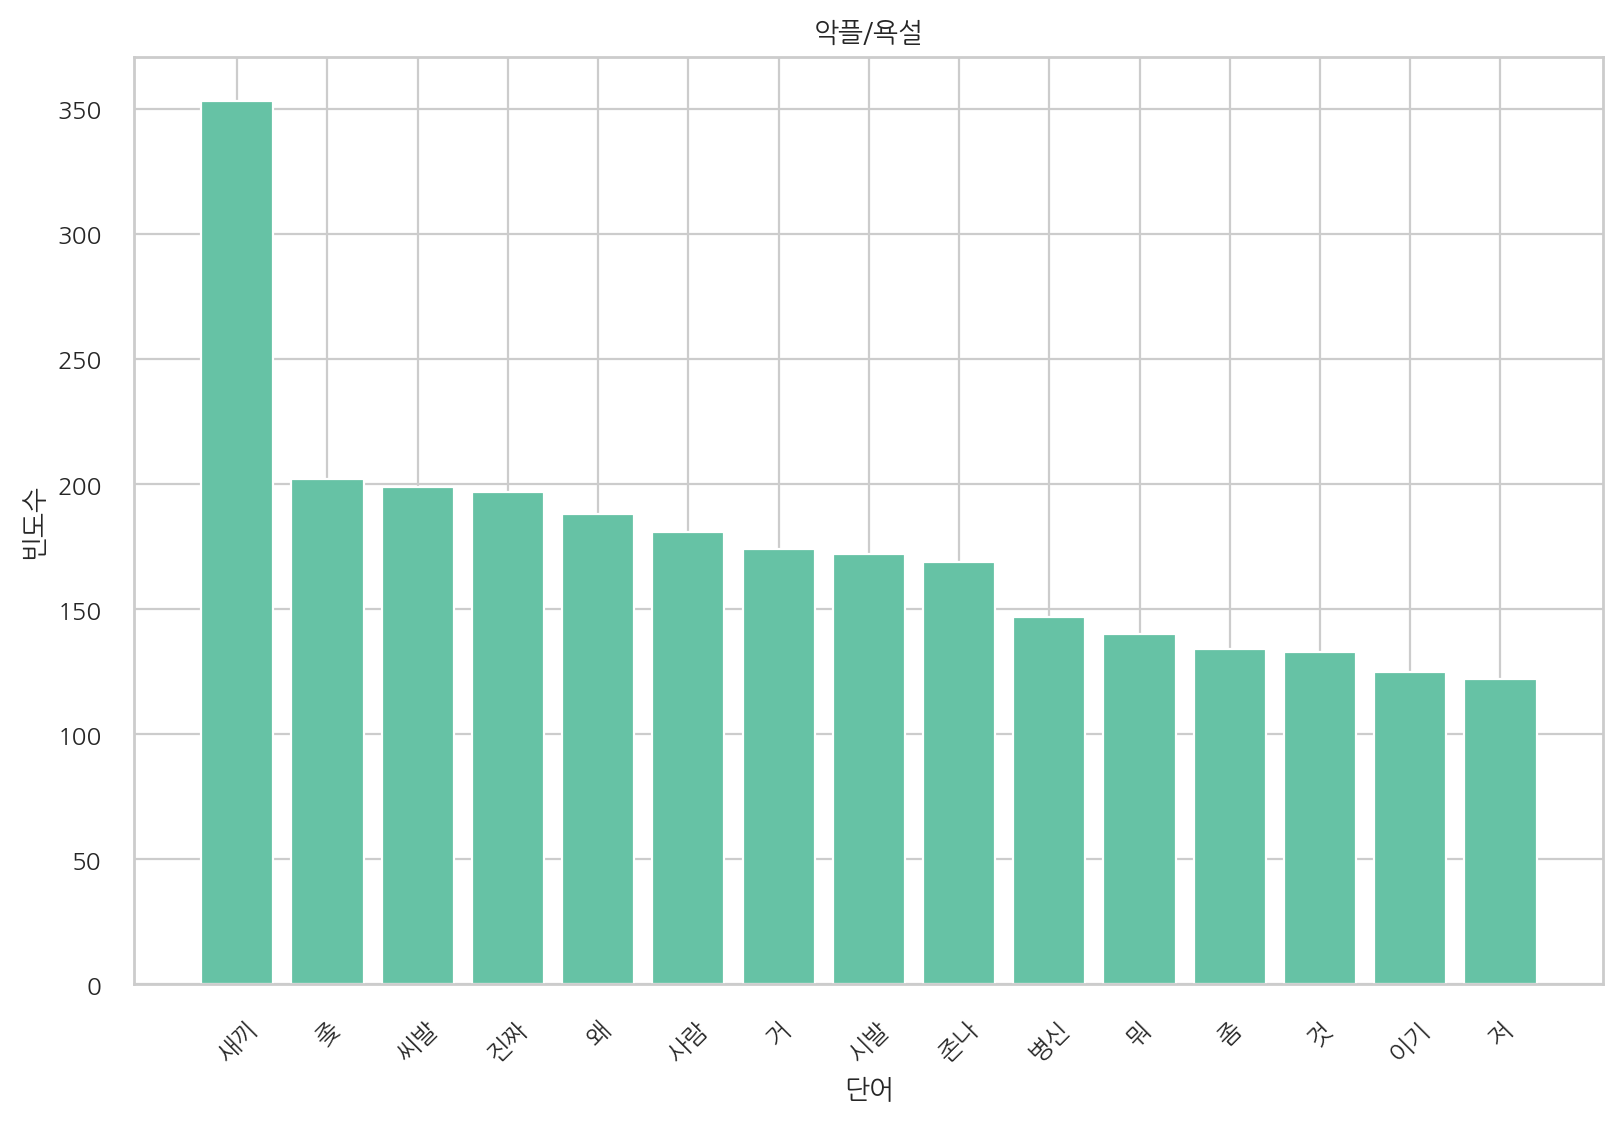

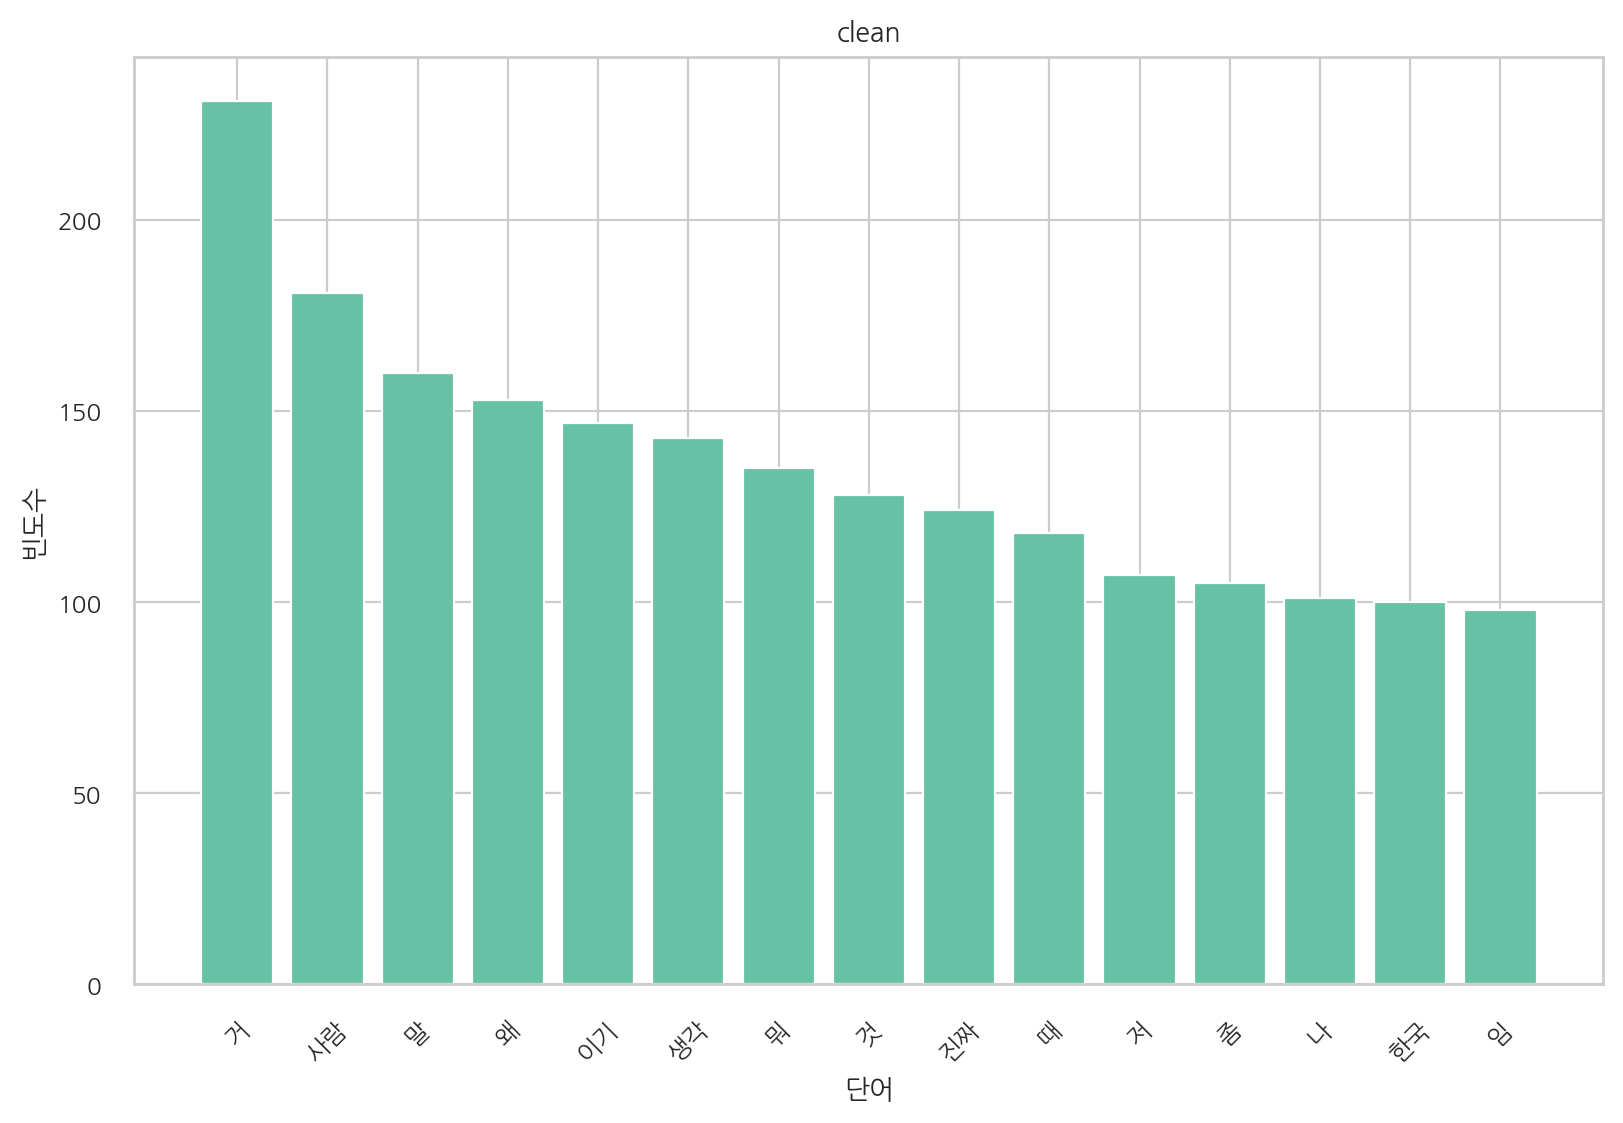

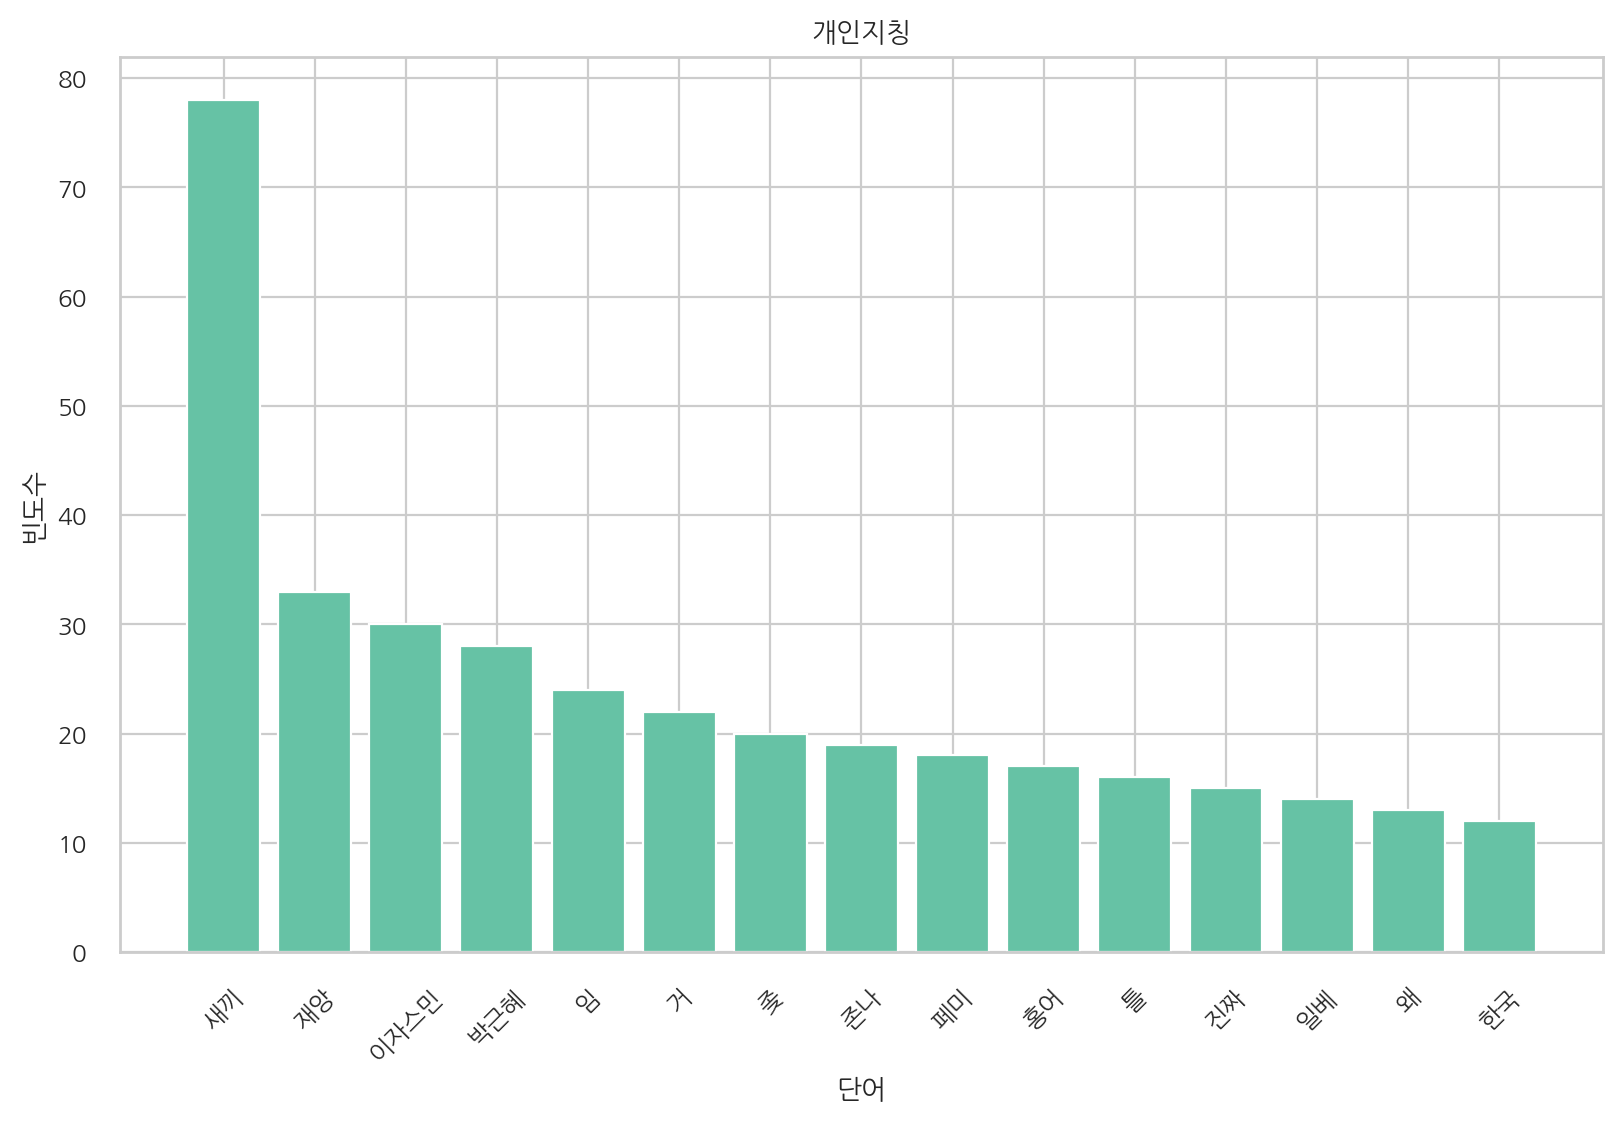

In [ ]:
# 문장 분석을 위해 코퍼스 만들기
from konlpy.tag import Okt
from tqdm import trange
tokenizer = Okt()

most_freq_nouns = []
key_list = ["여성/가족",	"남성",	"성소수자",	"인종/국적",	"연령",	"지역",	"종교",	"기타 혐오",	"악플/욕설",	"clean",	"개인지칭"]

# 각 클래스 별로 가장 많이 사용된 단어 찾아보기
for j in range(11):
    df_family = df[df[key_list[j]] == 1]
    sen_to_nouns=[]
    for i in trange(len(df_family['문장'])):
        for noun in tokenizer.nouns(df_family.iloc[i][0]):
            sen_to_nouns.append(noun)
    uniqqq_noun, counttt_noun = np.unique(np.array(sen_to_nouns), return_counts=True)

    # 딕셔너리 (개수, word 인덱스)
    count_index_noun = dict(zip(counttt_noun, uniqqq_noun))
    # # 가장 많이 사용된 단어의 갯수
    how_many_uses_noun = list(count_index_noun.keys())

    how_many_uses_noun.sort(reverse=True)
    how_many_uses_dict_noun = {count_index_noun[i]:i  for i in how_many_uses_noun}
    df_for_plot_noun = pd.DataFrame([how_many_uses_dict_noun]).T[:15]

    fig, ax = plt.subplots()
    ax.bar(df_for_plot_noun.index, df_for_plot_noun[0])
    ax.set_xticklabels(df_for_plot_noun.index,rotation = 45)
    ax.set_title(key_list[j])
    ax.set_xlabel('단어')
    ax.set_ylabel('빈도수');
    most_freq_nouns.append(df_for_plot_noun.index)

In [ ]:
display(df.head())
display(df.tail())

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
3732,저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ,0,1,0,0,0,0,0,0,0,0,0
3733,다른것보다 눈이 어떻게 저렇게 생기노.탄식.,0,0,0,0,0,0,0,0,1,0,0
3734,막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.,0,0,0,1,0,0,0,0,0,0,0
3735,‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...,1,0,0,0,0,0,0,0,0,0,0
3736,참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
display(df.head())
display(df.tail())

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
3732,저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ,0,1,0,0,0,0,0,0,0,0,0
3733,다른것보다 눈이 어떻게 저렇게 생기노.탄식.,0,0,0,0,0,0,0,0,1,0,0
3734,막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.,0,0,0,1,0,0,0,0,0,0,0
3735,‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...,1,0,0,0,0,0,0,0,0,0,0
3736,참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ,0,1,0,0,0,0,0,0,0,0,0
